In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
"""



import numpy as np
import csv
import string
import sys
import re
import spacy

csv.field_size_limit(sys.maxsize)



#from string import maketrans

articles = []

sources = {"New York Times", "Breitbart", "CNN", "Business Insider", "The Atlantic", "Fox News", "Talking Points Memo", "Buzzfeed News", "National Review", "New York Post", "The Guardian", "NPR", "Reuters", "Vox","The Washington Post"}


with open('all-the-news/articles1.csv', newline='') as csvfile:
   reader = csv.reader(csvfile, delimiter=',', quotechar='"')
   categories = csvfile.readline()   # skip the first line
   for i, line in enumerate(reader):
       articles.append(line)
       
with open('all-the-news/articles2.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    categories = csvfile.readline()   # skip the first line
    for i, line in enumerate(reader):
        articles.append(line)

with open('all-the-news/articles3.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    categories = csvfile.readline()   # skip the first line
    for i, line in enumerate(reader):
        articles.append(line)


for i, article in enumerate(articles):
    if not article[9]:
        articles.remove(article)
    
    
shortened_articles = articles[0:260]
print(articles[0][3])
for i, article in enumerate(articles):
    if(i == len(articles) - 2):
        break
    if(articles[i][3] != articles[i+1][3]):
        shortened_articles.extend(articles[i+1:i+261])
        print(articles[i + 1][3])


nlp = spacy.load('en', disable=['parser', 'ner'])




# put all the words in the article together bc they get split by commas in the csvread
for i, shortened_article in enumerate(shortened_articles):
    #Lemmatization
    doc = nlp(shortened_article[9])
    shortened_article[9] = " ".join([token.lemma_ for token in doc])
    shortened_article[9] = shortened_article[9].replace('-PRON- ', '')
    #article[9] += article[9+j]
    #remove all punctuation from the articles
    shortened_article[9] = re.sub(r'[^a-zA-Z]', " ", shortened_article[9].lower())
        #print(shortened_article[9])
    shortened_articles[i] = shortened_article[0:10]



PGoutput = shortened_articles[0:10]
TRoutput = shortened_articles[10:210]
TEoutput = shortened_articles[210:260]
print(shortened_articles[1][3])
#gather playground data
for i in range(1,15):
    index = i * 260
    PGoutput.extend(shortened_articles[index:index+10])
    TRoutput.extend(shortened_articles[index+10:index+210])
    TEoutput.extend(shortened_articles[index+210:index+260])
    #print(shortened_articles[i+1][3])


with open('playground_dataset.csv', 'w', newline='') as csvfile:
    outwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    for i in PGoutput:
        outwriter.writerow(i)
    
with open('train_dataset.csv', 'w', newline='') as csvfile:
    outwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    for i in TRoutput:
        outwriter.writerow(i)
        
with open('test_dataset.csv', 'w', newline='') as csvfile:
    outwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    for i in TEoutput:
        outwriter.writerow(i)
        
        
#glove vector code
file1 = open("vectors.txt","r")
Dict = {} 
for line in file1:
    line = line.split()
    Dict[line[0]] = np.array((line[1:])).astype(float)
file1.close()

New York Times
Breitbart
CNN
Business Insider
Atlantic
Fox News
Talking Points Memo
Buzzfeed News
National Review
New York Post
Guardian
NPR
Reuters
Vox
Washington Post
New York Times


In [3]:
# read in train and test csv's as pandas.DataFrame's
# pre-process the article titles in the same way as the article text

import pandas as pd

data_train = pd.read_csv('train_dataset.csv', sep=',', header=None).drop(labels=0, axis='columns')
#data_train.head(3)
data_train.columns = ['id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content']
#data_train.head(3)

data_test = pd.read_csv('test_dataset.csv', sep=',', header=None).drop(labels=0, axis='columns')
data_test.columns = ['id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content']
#data_test.head(3)

print(data_test['title'][0])
print(len(data_train))

# same pre-processing for title as article in case it is included in TF-IDF/LSA
for i in range(len(data_train)):
    #Lemmatization
    doc = nlp(data_train.loc[i, 'title'])
    new_title = " ".join([token.lemma_ for token in doc])
    new_title = new_title.replace('-PRON- ', '')
    new_title = re.sub(r'[^a-zA-Z]', " ", new_title.lower())
    data_train.loc[i, 'title'] = new_title
for i in range(len(data_test)):
    #Lemmatization
    doc = nlp(data_test.loc[i, 'title'])
    new_title = " ".join([token.lemma_ for token in doc])
    new_title = new_title.replace('-PRON- ', '')
    new_title = re.sub(r'[^a-zA-Z]', " ", new_title.lower())
    data_test.loc[i, 'title'] = new_title

Republicans, Facing Pressure, Delay Hearings for 4 Trump Cabinet Nominees - The New York Times
3000


In [4]:
# get just the relevant data for our problem: title, content, publication
content_data_train = data_train[['title', 'content', 'publication']]
content_data_test = data_test[['title', 'content', 'publication']]
content_title_data_train = pd.DataFrame(columns=['content', 'publication'])
content_title_data_test = pd.DataFrame(columns=['content', 'publication'])

# merge content and title into one document
for i in range(len(content_data_train)):
    content_title_data_train.loc[i, 'publication'] = content_data_train.loc[i, 'publication']
    # article titles often have '- Publication' at the end of the title - remove this bc too big a hint
    # (slightly stupid right now because it leaves the 'the' in 'the new york times')
    corrected_title = re.sub((content_data_train.loc[i, 'publication']).lower(), '', content_data_train.loc[i, 'title'])
    content_title_data_train.loc[i, 'content'] = corrected_title + ' ' + content_data_train.loc[i, 'content']
for i in range(len(content_data_test)):
    content_title_data_test.loc[i, 'publication'] = content_data_test.loc[i, 'publication']
    # article titles often have '- Publication' at the end of the title - remove this bc too big a hint
    corrected_title = re.sub((content_data_test.loc[i, 'publication']).lower(), '', content_data_test.loc[i, 'title'])
    content_title_data_test.loc[i, 'content'] = corrected_title + ' ' + content_data_test.loc[i, 'content']
#content_data_train.head()

In [5]:
# get train and test sets
X_train = {'content' : content_data_train.loc[:, 'content'], 'title' : content_title_data_train.loc[:, 'content']}
X_test = {'content' : content_data_test.loc[:, 'content'], 'title' : content_title_data_test.loc[:, 'content']}
unique_publications = list(set(content_data_train.loc[:, 'publication']))
label_dict = {}
for i in range(len(unique_publications)):
    label_dict[unique_publications[i]] = i
y_train = {'content': [label_dict[pub] for pub in content_data_train.loc[:, 'publication']], 'title': [label_dict[pub] for pub in content_title_data_train.loc[:, 'publication']]}
y_test = {'content': [label_dict[pub] for pub in content_data_test.loc[:, 'publication']], 'title': [label_dict[pub] for pub in content_title_data_test.loc[:, 'publication']]}

In [30]:
# get tf-idf vectorizers (we want to tune max_df, so we try values in [0.25, 0.5, 1.])
# we also want to tune the largest n-grams considered, so 
from sklearn.feature_extraction.text import TfidfVectorizer

max_dfs = [0.25, 0.5, 1.]
max_ngram = [1, 2, 3]

vectorizers = {}
for max_n in max_ngram:
    vectorizers[max_n] = {'content': [], 'title': []}
    
    for max_df in max_dfs:
        vectorizers[max_n]['content'].append(TfidfVectorizer(max_df=max_df, min_df=10, stop_words='english', ngram_range=(1,max_n)))
        vectorizers[max_n]['title'].append(TfidfVectorizer(max_df=max_df, min_df=10, stop_words='english', ngram_range=(1,max_n)))
#print(len(vectorizers))

# get term-document matrices (entries are tf-idf for each word) for train and test set
X_train_tfidf = {}
for max_n in max_ngram:
    X_train_tfidf[max_n] = {}
    for k, v in X_train.items():
        X_train_tfidf[max_n][k] = []
        for i in range(len(max_dfs)):
            X_train_tfidf[max_n][k].append(vectorizers[max_n][k][i].fit_transform(X_train[k]))
            print('n_grams ', max_n, ' training ', k, ' max_df ', max_dfs[i], ' done')
        
X_test_tfidf = {}
for max_n in max_ngram:
    X_test_tfidf[max_n] = {}
    for k, v in X_test.items():
        X_test_tfidf[max_n][k] = []
        for i in range(len(max_dfs)):
            X_test_tfidf[max_n][k].append(vectorizers[max_n][k][i].transform(X_test[k]))
            print('n_grams ', max_n, ' test ', k, ' max_df ', max_dfs[i], ' done')

n_grams  1  training  content  max_df  0.25  done
n_grams  1  training  content  max_df  0.5  done
n_grams  1  training  content  max_df  1.0  done
n_grams  1  training  title  max_df  0.25  done
n_grams  1  training  title  max_df  0.5  done
n_grams  1  training  title  max_df  1.0  done
n_grams  2  training  content  max_df  0.25  done
n_grams  2  training  content  max_df  0.5  done
n_grams  2  training  content  max_df  1.0  done
n_grams  2  training  title  max_df  0.25  done
n_grams  2  training  title  max_df  0.5  done
n_grams  2  training  title  max_df  1.0  done
n_grams  3  training  content  max_df  0.25  done
n_grams  3  training  content  max_df  0.5  done
n_grams  3  training  content  max_df  1.0  done
n_grams  3  training  title  max_df  0.25  done
n_grams  3  training  title  max_df  0.5  done
n_grams  3  training  title  max_df  1.0  done
n_grams  1  test  content  max_df  0.25  done
n_grams  1  test  content  max_df  0.5  done
n_grams  1  test  content  max_df  1.0 

750
1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.250000, 1-grams')]

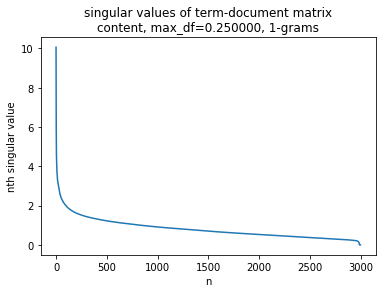

In [31]:
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt

# 1-grams, content, max_df=0.25
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['content'][0]
print(len(X_test['content']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[0], 1)))

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa = {}
lsa[1] = {}
lsa[1]['content'] = []
(lsa[1]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa = {}
X_train_lsa[1] = {}
X_train_lsa[1]['content'] = []
(X_train_lsa[1]['content']).append(lsa[1]['content'][0].fit_transform(X_train_tfidf[1]['content'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
X_test_lsa = {}
X_test_lsa[1] = {}
X_test_lsa[1]['content'] = []
(X_test_lsa[1]['content']).append(lsa[1]['content'][0].transform(X_test_tfidf[1]['content'][0]))

0.7695062260238197


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.250000, 2-grams')]

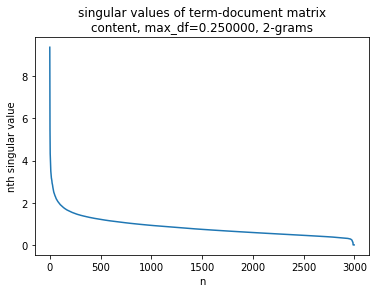

In [33]:
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['content'][0]

# 2-grams, content, max_df=0.25
# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[0], 2)))

In [34]:
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa[2] = {}
lsa[2]['content'] = []
(lsa[2]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa[2] = {}
X_train_lsa[2]['content'] = []
(X_train_lsa[2]['content']).append(lsa[2]['content'][0].fit_transform(X_train_tfidf[2]['content'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
X_test_lsa[2] = {}
X_test_lsa[2]['content'] = []
(X_test_lsa[2]['content']).append(lsa[2]['content'][0].transform(X_test_tfidf[2]['content'][0]))

0.7470377480267556


1.0


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.250000, 3-grams')]

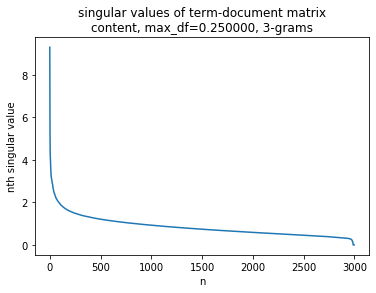

In [35]:
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['content'][0]

# 3-grams, content, max_df=0.25
# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[0], 3)))

In [36]:
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa[3] = {}
lsa[3]['content'] = []
(lsa[3]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa[3] = {}
X_train_lsa[3]['content'] = []
(X_train_lsa[3]['content']).append(lsa[3]['content'][0].fit_transform(X_train_tfidf[3]['content'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
X_test_lsa[3] = {}
X_test_lsa[3]['content'] = []
(X_test_lsa[3]['content']).append(lsa[3]['content'][0].transform(X_test_tfidf[3]['content'][0]))

0.7488507932520769


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.500000, 1-grams')]

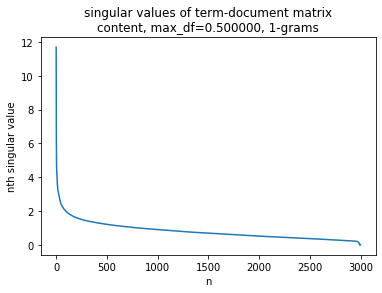

In [37]:
# 1-grams, content, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['content'][1]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[1], 1)))

In [38]:
# 1000 also seems reasonable for this given scree plot
rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[1]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[1]['content']).append(lsa[1]['content'][1].fit_transform(X_train_tfidf[1]['content'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[1]['content']).append(lsa[1]['content'][1].transform(X_test_tfidf[1]['content'][1]))

0.7736274486499696


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.500000, 2-grams')]

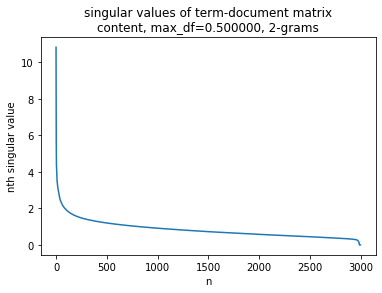

In [39]:
# 2-grams, content, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['content'][1]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[1], 2)))

In [40]:
# 1000 also seems reasonable for this given scree plot
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[2]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[2]['content']).append(lsa[2]['content'][1].fit_transform(X_train_tfidf[2]['content'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[2]['content']).append(lsa[2]['content'][1].transform(X_test_tfidf[2]['content'][1]))

0.751985980682936


1.0


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=0.500000, 3-grams')]

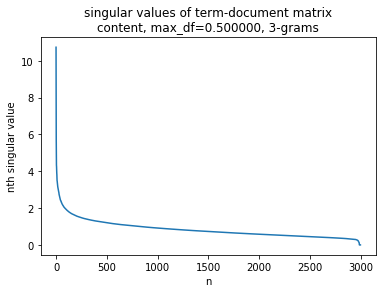

In [41]:
# 3-grams, content, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['content'][1]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[1], 3)))

In [42]:
# 1000 also seems reasonable for this given scree plot
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[3]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[3]['content']).append(lsa[3]['content'][1].fit_transform(X_train_tfidf[3]['content'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[3]['content']).append(lsa[3]['content'][1].transform(X_test_tfidf[3]['content'][1]))

0.7536362626410547


1.0


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=1.000000, 1-grams')]

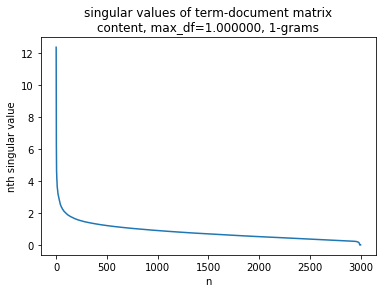

In [43]:
# 1-grams, content, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['content'][2]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[2], 1)))

In [44]:
# 500 also seems reasonable for this given scree plot
rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['content'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[1]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[1]['content']).append(lsa[1]['content'][2].fit_transform(X_train_tfidf[1]['content'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[1]['content']).append(lsa[1]['content'][2].transform(X_test_tfidf[1]['content'][2]))

0.7744791203640696


1.0


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=1.000000, 2-grams')]

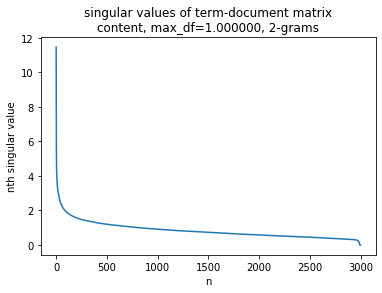

In [45]:
# 2-grams, content, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['content'][2]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[2], 2)))

In [46]:
# 500 also seems reasonable for this given scree plot
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['content'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[2]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[2]['content']).append(lsa[2]['content'][2].fit_transform(X_train_tfidf[2]['content'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[2]['content']).append(lsa[2]['content'][2].transform(X_test_tfidf[2]['content'][2]))

0.752895946936116


1.0000000000000004


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ncontent, max_df=1.000000, 3-grams')]

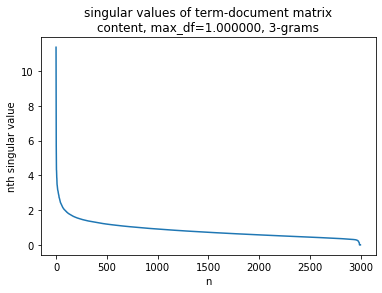

In [47]:
# 3-grams, content, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['content'][2]

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ncontent, max_df=%f, %d-grams' % (max_dfs[2], 3)))

In [48]:
# 500 also seems reasonable for this given scree plot
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['content'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[3]['content']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[3]['content']).append(lsa[3]['content'][2].fit_transform(X_train_tfidf[3]['content'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[3]['content']).append(lsa[3]['content'][2].transform(X_test_tfidf[3]['content'][2]))

0.7545393280918429


750
0.9999999999999994


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.250000, 1-grams')]

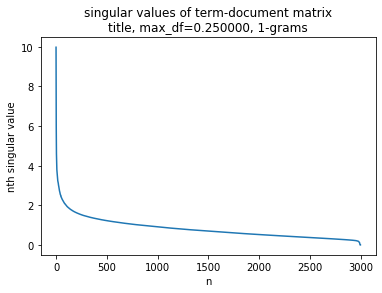

In [49]:
# now do same thing for pre-pending title of the article to content
# 1-grams, title, max_df=0.25
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['title'][0]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[0], 1)))

In [51]:
# 500 seems reasonable
rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa[1]['title'] = []
(lsa[1]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa[1]['title'] = []
(X_train_lsa[1]['title']).append(lsa[1]['title'][0].fit_transform(X_train_tfidf[1]['title'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
#X_test_lsa = {}
X_test_lsa[1]['title'] = []
(X_test_lsa[1]['title']).append(lsa[1]['title'][0].transform(X_test_tfidf[1]['title'][0]))

0.7731862204172733


750
1.0000000000000004


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.250000, 2-grams')]

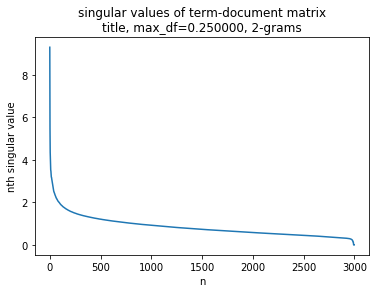

In [52]:
# 2-grams, title, max_df=0.25
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['title'][0]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[0], 2)))

In [53]:
# 500 seems reasonable
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa[2]['title'] = []
(lsa[2]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa[2]['title'] = []
(X_train_lsa[2]['title']).append(lsa[2]['title'][0].fit_transform(X_train_tfidf[2]['title'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
#X_test_lsa = {}
X_test_lsa[2]['title'] = []
(X_test_lsa[2]['title']).append(lsa[2]['title'][0].transform(X_test_tfidf[2]['title'][0]))

0.7510763625798396


750
0.9999999999999996


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.250000, 3-grams')]

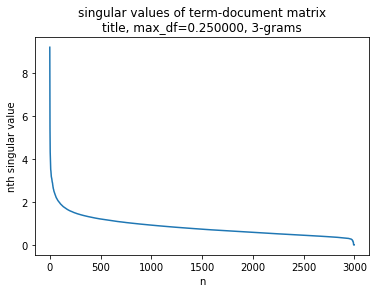

In [54]:
# 3-grams, title, max_df=0.25
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['title'][0]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][0])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[0], 3)))

In [55]:
# 500 seems reasonable
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][0])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
lsa[3]['title'] = []
(lsa[3]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
X_train_lsa[3]['title'] = []
(X_train_lsa[3]['title']).append(lsa[3]['title'][0].fit_transform(X_train_tfidf[3]['title'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
#X_test_lsa = {}
X_test_lsa[3]['title'] = []
(X_test_lsa[3]['title']).append(lsa[3]['title'][0].transform(X_test_tfidf[3]['title'][0]))

0.7527818937502078


750
1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.500000, 1-grams')]

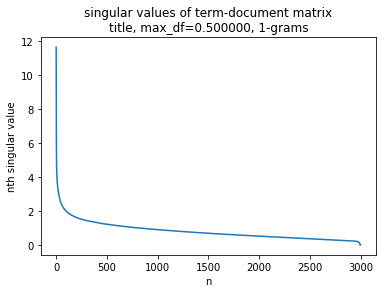

In [56]:
# 1-grams, title, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['title'][1]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[1], 1)))

In [57]:
# 500 seems reasonable
rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[1]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[1]['title']).append(lsa[1]['title'][1].fit_transform(X_train_tfidf[1]['title'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[1]['title']).append(lsa[1]['title'][1].transform(X_test_tfidf[1]['title'][1]))

0.7771804232626066


750
1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.500000, 2-grams')]

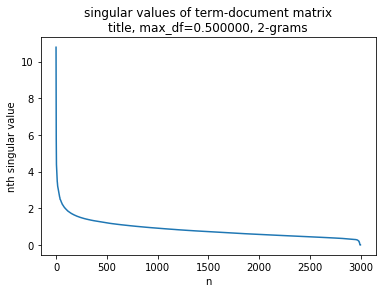

In [58]:
# 2-grams, title, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['title'][1]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[1], 2)))

In [59]:
# 500 seems reasonable
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[2]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[2]['title']).append(lsa[2]['title'][1].fit_transform(X_train_tfidf[2]['title'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[2]['title']).append(lsa[2]['title'][1].transform(X_test_tfidf[2]['title'][1]))

0.7559692403750742


750
1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=0.500000, 3-grams')]

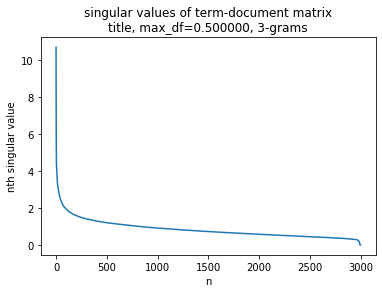

In [60]:
# 3-grams, title, max_df=0.5
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['title'][1]
print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][1])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[1], 3)))

In [61]:
# 500 seems reasonable
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][1])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[3]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[3]['title']).append(lsa[3]['title'][1].fit_transform(X_train_tfidf[3]['title'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[3]['title']).append(lsa[3]['title'][1].transform(X_test_tfidf[3]['title'][1]))

0.7575354961818466


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=1.000000, 1-grams')]

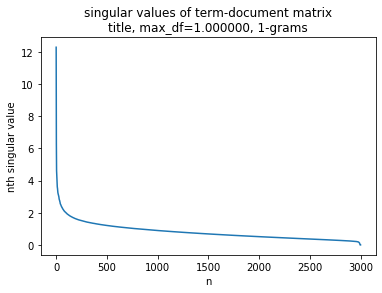

In [62]:
# 1-grams, title, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[1]['title'][2]
#print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[2], 1)))

In [63]:
# 500 seems reasonable
rank = 1000
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[1]['title'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[1]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[1]['title']).append(lsa[1]['title'][2].fit_transform(X_train_tfidf[1]['title'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[1]['title']).append(lsa[1]['title'][2].transform(X_test_tfidf[1]['title'][2]))

0.7779658954830418


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=1.000000, 2-grams')]

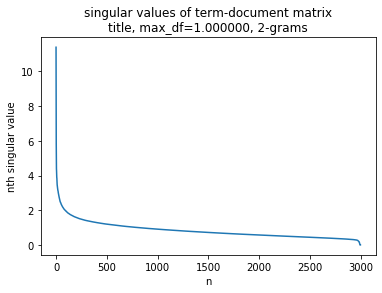

In [64]:
# 2-grams, title, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[2]['title'][2]
#print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[2], 2)))

In [65]:
# 500 seems reasonable
rank = 1050
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[2]['title'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[2]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[2]['title']).append(lsa[2]['title'][2].fit_transform(X_train_tfidf[2]['title'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[2]['title']).append(lsa[2]['title'][2].transform(X_test_tfidf[2]['title'][2]))

0.7568542592277008


1.0000000000000002


[Text(0, 0.5, 'nth singular value'),
 Text(0.5, 0, 'n'),
 Text(0.5, 1.0, 'singular values of term-document matrix\ntitle, max_df=1.000000, 3-grams')]

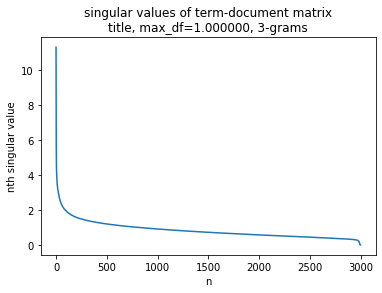

In [66]:
# 3-grams, title, max_df=1.0
# experiment with a good reduced rank to find one that explains most of the variance in the term-document matrices
X_train_tfidf[3]['title'][2]
#print(len(X_test['title']))

# plot the singular values (scree plot) to find a knee that suggests underlying low rank structure
rank = 2999
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][2])
print(svd.explained_variance_ratio_.sum())
fig, ax = plt.subplots()
ax.plot(svd.singular_values_)
ax.set(xlabel='n', ylabel='nth singular value', title = ('singular values of term-document matrix\ntitle, max_df=%f, %d-grams' % (max_dfs[2], 3)))

In [67]:
# 500 seems reasonable
rank = 1060
svd = TruncatedSVD(rank)
svd.fit(X_train_tfidf[3]['title'][2])
print(svd.explained_variance_ratio_.sum())

# dictionary of TruncatedSVD transforms
(lsa[3]['title']).append(make_pipeline(svd, Normalizer(copy=False)))

# dictionary of tf-idf training data after TruncatedSVD transform
(X_train_lsa[3]['title']).append(lsa[3]['title'][2].fit_transform(X_train_tfidf[3]['title'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa[3]['title']).append(lsa[3]['title'][2].transform(X_test_tfidf[3]['title'][2]))

0.7583555598310412


In [68]:
# sanity check lengths
print(len(X_train))
print(len(X_train['content']))
print(len(X_train['title']))
print(len(X_test))
print(len(X_test['content']))
print(len(X_test['title']))

print(len(X_train_tfidf))
for n in max_ngram:
    print(len(X_train_tfidf[n]['content']))
    print(X_train_tfidf[n]['content'][0].shape)
    print(X_train_tfidf[n]['content'][1].shape)
    print(X_train_tfidf[n]['content'][2].shape)
    print(len(X_train_tfidf[n]['title']))
    print(X_train_tfidf[n]['title'][0].shape)
    print(X_train_tfidf[n]['title'][1].shape)
    print(X_train_tfidf[n]['title'][2].shape)

print(len(X_test_tfidf))
for n in max_ngram:
    print(len(X_test_tfidf[n]['content']))
    print(X_test_tfidf[n]['content'][0].shape)
    print(X_test_tfidf[n]['content'][1].shape)
    print(X_test_tfidf[n]['content'][2].shape)
    print(len(X_test_tfidf[n]['title']))
    print(X_test_tfidf[n]['title'][0].shape)
    print(X_test_tfidf[n]['title'][1].shape)
    print(X_test_tfidf[n]['title'][2].shape)

print(len(lsa))
for n in max_ngram:
    print(len(lsa[n]['content']))
    print(len(lsa[n]['title']))

print(len(X_train_lsa))
for n in max_ngram:
    print(len(X_train_lsa[n]['content']))
    print(X_train_lsa[n]['content'][0].shape)
    print(X_train_lsa[n]['content'][1].shape)
    print(X_train_lsa[n]['content'][2].shape)
    print(len(X_train_lsa[n]['title']))
    print(X_train_lsa[n]['title'][0].shape)
    print(X_train_lsa[n]['title'][1].shape)
    print(X_train_lsa[n]['title'][2].shape)

print(len(X_test_lsa))
for n in max_ngram:
    print(len(X_test_lsa[n]['content']))
    print(X_test_lsa[n]['content'][0].shape)
    print(X_test_lsa[n]['content'][1].shape)
    print(X_test_lsa[n]['content'][2].shape)
    print(len(X_test_lsa[n]['title']))
    print(X_test_lsa[n]['title'][0].shape)
    print(X_test_lsa[n]['title'][1].shape)
    print(X_test_lsa[n]['title'][2].shape)

print(len(y_train))
print(len(y_train['content']))
print(len(y_train['title']))

print(len(y_test))
print(len(y_test['content']))
print(len(y_test['title']))

2
3000
3000
2
750
750
3
3
(3000, 8309)
(3000, 8381)
(3000, 8391)
3
(3000, 8345)
(3000, 8418)
(3000, 8428)
3
(3000, 13959)
(3000, 14032)
(3000, 14042)
3
(3000, 14089)
(3000, 14163)
(3000, 14173)
3
(3000, 14861)
(3000, 14934)
(3000, 14944)
3
(3000, 15003)
(3000, 15077)
(3000, 15087)
3
3
(750, 8309)
(750, 8381)
(750, 8391)
3
(750, 8345)
(750, 8418)
(750, 8428)
3
(750, 13959)
(750, 14032)
(750, 14042)
3
(750, 14089)
(750, 14163)
(750, 14173)
3
(750, 14861)
(750, 14934)
(750, 14944)
3
(750, 15003)
(750, 15077)
(750, 15087)
3
3
3
3
3
3
3
3
3
(3000, 1000)
(3000, 1000)
(3000, 1000)
3
(3000, 1000)
(3000, 1000)
(3000, 1000)
3
(3000, 1050)
(3000, 1050)
(3000, 1050)
3
(3000, 1050)
(3000, 1050)
(3000, 1050)
3
(3000, 1060)
(3000, 1060)
(3000, 1060)
3
(3000, 1060)
(3000, 1060)
(3000, 1060)
3
3
(750, 1000)
(750, 1000)
(750, 1000)
3
(750, 1000)
(750, 1000)
(750, 1000)
3
(750, 1050)
(750, 1050)
(750, 1050)
3
(750, 1050)
(750, 1050)
(750, 1050)
3
(750, 1060)
(750, 1060)
(750, 1060)
3
(750, 1060)
(750, 10

{'Breitbart': 0, 'Washington Post': 1, 'CNN': 2, 'Business Insider': 3, 'Buzzfeed News': 4, 'NPR': 5, 'New York Times': 6, 'Reuters': 7, 'New York Post': 8, 'Vox': 9, 'Talking Points Memo': 10, 'Guardian': 11, 'Atlantic': 12, 'National Review': 13, 'Fox News': 14}
{0: 'Breitbart', 1: 'Washington Post', 2: 'CNN', 3: 'Business Insider', 4: 'Buzzfeed News', 5: 'NPR', 6: 'New York Times', 7: 'Reuters', 8: 'New York Post', 9: 'Vox', 10: 'Talking Points Memo', 11: 'Guardian', 12: 'Atlantic', 13: 'National Review', 14: 'Fox News'}
[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3

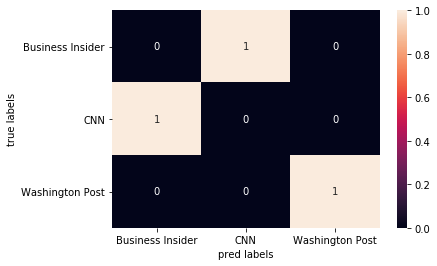

In [109]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import seaborn as sns

algorithm_comparison = pd.DataFrame(columns=['algorithm', 'n_train', 'n_test', 'use_title', 'max_df', 'n-gram', 'cv_score', 'train_acc', 'test_acc'])
cv_results = {'title': [None]*3, 'content': [None]*3}

label_dict = {'Breitbart': 0, 'Washington Post': 1, 'CNN': 2, 'Business Insider': 3, 'Buzzfeed News': 4, 'NPR': 5, 'New York Times': 6, 'Reuters': 7, 'New York Post': 8, 'Vox': 9, 'Talking Points Memo': 10, 'Guardian': 11, 'Atlantic': 12, 'National Review': 13, 'Fox News': 14}
label_dict_inv = {}
for k, v  in label_dict.items():
    label_dict_inv[v] = k
print(label_dict)
print(label_dict_inv)

print(y_test['title'])
blah = [1, 2, 3]
blahblah = [1, 3, 2]
blah = [label_dict_inv[j] for j in blah]
blahblah = [label_dict_inv[j] for j in blahblah]
result_dataframe = pd.DataFrame(columns=['true labels', 'pred labels'])
result_dataframe.loc[:,'true labels'] = blah
result_dataframe.loc[:,'pred labels'] = blahblah
mat = pd.crosstab(result_dataframe['true labels'], result_dataframe['pred labels'])
sns.heatmap(mat, annot=True)
plt.show()

best_models = {} # maps i (row in the DataFrame table) to the best model
best_conf_mat = {} # maps i (row in the DataFrame table) to the confusion matrix 
                    # (a cross-tabulated pd.DataFrame) for the best model

def algorithm_score(classifier, params, use_title, vectorizer_idx, i, algo_name):
    # use_title: True or False - if pre-pending title to article content
    # vectorizer_idx: (n_gram, idx)
    #      n_gram - 1, 2, 3 - max words used in n-grams
    #      idx - 0, 1, 2 - idx corresponding to max document frequency (0 has max_df=0.25, 1 has max_df=0.5, 2 has max_df=1.)
    key = 'title' if use_title else 'content'
    n = vectorizer_idx[0]
    df = vectorizer_idx[1]
    
    algorithm_comparison.loc[i, 'use_title'] = key
    algorithm_comparison.loc[i, 'max_df'] = max_dfs[df]
    algorithm_comparison.loc[i, 'n-gram'] = n
    
    print('use_title: ', key, ', max_df: ', max_dfs[df], 'n-gram: ', n)
    
    # 5-fold cross-validation
    grid_search = GridSearchCV(classifier, params, cv=5, verbose=2)
    grid_search.fit(np.array(X_train_lsa[n][key][df]), np.array(y_train[key]))
    cv_results[key][df] = grid_search.cv_results_
    
    # compute accuracies with best result from cross-validation
    best = grid_search.best_estimator_
    print('Best parameters: ', grid_search.best_params_)
    
    # show best scores for cross-validation
    cv_score = cross_val_score(best, X=np.array(X_train_lsa[n][key][df]), y = np.array(y_train[key]), cv=5)
    print('CV score for each fold (best estimator): ', cv_score)
    print('CV score averaged across folds (best estimator): ', cv_score.mean())
    algorithm_comparison.loc[i, 'cv_score'] = cv_score.mean()
    
    
    # use best parameters on whole training 
    best_all = best.fit(np.array(X_train_lsa[n][key][df]), np.array(y_train[key]))
    best_models[i] = best_all
    
    # use best parameters on whole training set for train accuracy
    train_acc = best_all.score(X=np.array(X_train_lsa[n][key][df]), y=np.array(y_train[key]))
    print('Training accuracy (best estimator): ', train_acc)
    algorithm_comparison.loc[i, 'train_acc'] = train_acc
    
    # use best parameters on whole training set for test accuracy
    test_acc = best_all.score(X=np.array(X_test_lsa[n][key][df]), y=np.array(y_test[key]))
    print('Test accuracy (best estimator): ', test_acc)
    algorithm_comparison.loc[i, 'test_acc'] = test_acc
    
    # create confusion matrix
    y_pred = best_all.predict(np.array(X_test_lsa[n][key][df]))
    #conf_mat = pd.crosstab(np.array(y_test[key]), y_pred)
    
    true_names = [label_dict_inv[j] for j in y_test[key]]
    pred_names = [label_dict_inv[j] for j in y_pred]
    result_dataframe = pd.DataFrame(columns=['true labels', 'predicted labels'])
    result_dataframe.loc[:,'true labels'] = true_names
    result_dataframe.loc[:,'predicted labels'] = pred_names

    plt.figure()
    conf_mat = pd.crosstab(result_dataframe['true labels'], result_dataframe['predicted labels'])
    best_conf_mat[i] = conf_mat
    sns.heatmap(conf_mat, annot=True)
    plt.title('Confusion Matrix: %s Classifier\n%s, max_df=%.2f, n-grams=%d' % (algo_name, key, max_dfs[df], n))
    plt.tight_layout()
    plt.savefig('confmat_%s_%s_%.2f_%d_i%d.png' % (algo_name, key, max_dfs[df], n, i))
    
    algorithm_comparison.loc[i, 'n_train'] = len(y_train[key])
    algorithm_comparison.loc[i, 'n_test'] = len(y_test[key])
    
    #return best_all
       

----Random Forest-----
use_title:  title , max_df:  1.0 n-gram:  1
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] criterion=entropy, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... criterion=entropy, n_estimators=10, total=  22.7s
[CV] criterion=entropy, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.7s remaining:    0.0s


[CV] ............... criterion=entropy, n_estimators=10, total=  20.1s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  20.8s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  20.7s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  20.6s
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.6min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.6min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.6min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 38.4min finished


Best parameters:  {'criterion': 'gini', 'n_estimators': 100}
CV score for each fold (best estimator):  [0.3        0.33333333 0.30833333 0.33833333 0.29833333]
CV score averaged across folds (best estimator):  0.31566666666666665
Training accuracy (best estimator):  1.0
Test accuracy (best estimator):  0.32
----Random Forest-----
use_title:  title , max_df:  1.0 n-gram:  2
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] criterion=entropy, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... criterion=entropy, n_estimators=10, total=  22.8s
[CV] criterion=entropy, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.8s remaining:    0.0s


[CV] ............... criterion=entropy, n_estimators=10, total=  23.2s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  34.0s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  35.6s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  22.9s
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.8min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.7min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.7min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 39.9min finished


Best parameters:  {'criterion': 'gini', 'n_estimators': 100}
CV score for each fold (best estimator):  [0.33       0.375      0.35166667 0.34833333 0.31333333]
CV score averaged across folds (best estimator):  0.3436666666666667
Training accuracy (best estimator):  1.0
Test accuracy (best estimator):  0.3373333333333333
----Random Forest-----
use_title:  title , max_df:  1.0 n-gram:  3
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] criterion=entropy, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............... criterion=entropy, n_estimators=10, total=  21.7s
[CV] criterion=entropy, n_estimators=10 ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.7s remaining:    0.0s


[CV] ............... criterion=entropy, n_estimators=10, total=  22.2s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  23.2s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  21.7s
[CV] criterion=entropy, n_estimators=10 ..............................
[CV] ............... criterion=entropy, n_estimators=10, total=  21.2s
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.7min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.8min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] ............... criterion=entropy, n_estimators=50, total= 1.8min
[CV] criterion=entropy, n_estimators=50 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 40.1min finished


Best parameters:  {'criterion': 'entropy', 'n_estimators': 100}
CV score for each fold (best estimator):  [0.31666667 0.355      0.37333333 0.33666667 0.33      ]
CV score averaged across folds (best estimator):  0.3423333333333333
Training accuracy (best estimator):  1.0
Test accuracy (best estimator):  0.31866666666666665


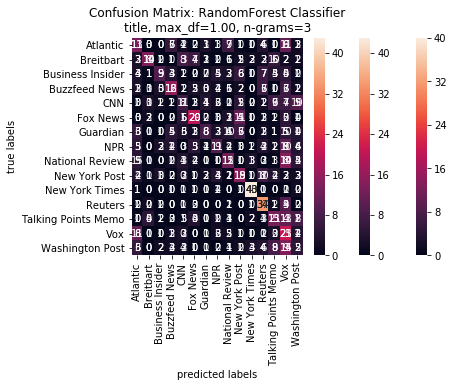

In [92]:
from sklearn.ensemble import RandomForestClassifier

params = {'criterion': ['entropy', 'gini'],
         'n_estimators': [10, 50, 100]}

i = 0

for n in max_ngram:
    classifier = RandomForestClassifier(max_features=None, n_jobs=-1)
    print('----Random Forest-----')
    algorithm_comparison.loc[i, 'algorithm'] = 'RandomForest'
    # chose one with highest variance explained by SVD
    algorithm_score(classifier, params, True, (n, 2), i, 'RandomForest')
    i += 1

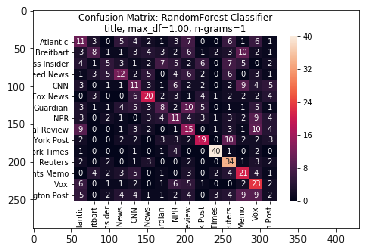

3


In [95]:
algorithm_comparison.head(3)
img = plt.imread('confmat_RandomForest_title_1.00_1.png')
plt.imshow(img)
plt.show()
print(i)

In [108]:
# test plotting the decision trees from a RandomForest classifier - https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
print(iris.feature_names)
print(iris.target_names)

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = False)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

class_names = [label_dict_inv[cls] for cls in range(15)]
print(label_dict)
print(label_dict_inv)
print(class_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
{'Breitbart': 0, 'Washington Post': 1, 'CNN': 2, 'Business Insider': 3, 'Buzzfeed News': 4, 'NPR': 5, 'New York Times': 6, 'Reuters': 7, 'New York Post': 8, 'Vox': 9, 'Talking Points Memo': 10, 'Guardian': 11, 'Atlantic': 12, 'National Review': 13, 'Fox News': 14}
{0: 'Breitbart', 1: 'Washington Post', 2: 'CNN', 3: 'Business Insider', 4: 'Buzzfeed News', 5: 'NPR', 6: 'New York Times', 7: 'Reuters', 8: 'New York Post', 9: 'Vox', 10: 'Talking Points Memo', 11: 'Guardian', 12: 'Atlantic', 13: 'National Review', 14: 'Fox News'}
['Breitbart', 'Washington Post', 'CNN', 'Business Insider', 'Buzzfeed News', 'NPR', 'New York Times', 'Reuters', 'New York Post', 'Vox', 'Talking Points Memo', 'Guardian', 'Atlantic', 'National Review', 'Fox News']


----Random Forest-----
use_title:  title , max_df:  1.0 n-gram:  1
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] criterion=entropy ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ criterion=entropy, total= 8.1min
[CV] criterion=entropy ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.1min remaining:    0.0s


[CV] ................................ criterion=entropy, total= 7.9min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 7.5min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 8.5min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 7.8min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 3.1min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 3.2min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 3.6min
[CV] criterion=gini ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 56.7min finished


Best parameters:  {'criterion': 'entropy'}
CV score for each fold (best estimator):  [0.335      0.34833333 0.35166667 0.34166667 0.33      ]
CV score averaged across folds (best estimator):  0.3413333333333334
Training accuracy (best estimator):  1.0
Test accuracy (best estimator):  0.33066666666666666


KeyError: 4

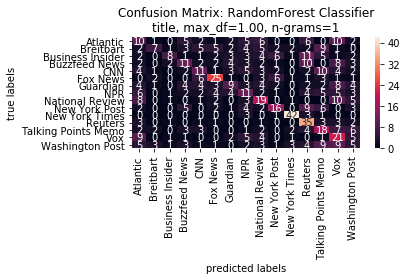

In [110]:
params = {'criterion': ['entropy', 'gini']}
class_names = [label_dict_inv[cls] for cls in range(15)]

for n in max_ngram:
    classifier = RandomForestClassifier(max_features=None, n_jobs=-1, n_estimators=200)
    print('----Random Forest-----')
    algorithm_comparison.loc[i, 'algorithm'] = 'RandomForest'
    # chose one with highest variance explained by SVD
    algorithm_score(classifier, params, True, (n, 2), i, 'RandomForest')
    
    # show 3 of the decision trees used
    for samp in range(3):
        est_idx = np.random.randint(0, high=200)
        estimator = best_models[i].estimators_[est_idx]
        fname = 'RandomForest_i%d_tree%d_%d' % (i, est_idx, samp)
        
        export_graphviz(estimator, out_file=(fname+'.dot'), class_names=class_names,
                       filled=False, rounded=True, precision=2, proportion=True)
        call(['dot', '-Tpng', fname+'.dot', '-o', fname+'.png'])
    i += 1

4


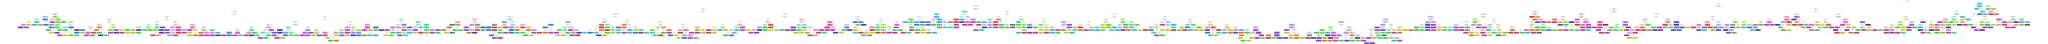

In [114]:
print(i)
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

graph = Source(export_graphviz(estimator, out_file=None,
               class_names=class_names,
               filled = True))
display(SVG(graph.pipe(format='svg')))

----Random Forest-----
use_title:  title , max_df:  1.0 n-gram:  2
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] criterion=entropy ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ criterion=entropy, total= 6.8min
[CV] criterion=entropy ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s


[CV] ................................ criterion=entropy, total= 6.6min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 6.8min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 6.6min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 7.5min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 2.8min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 2.9min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 3.0min
[CV] criterion=gini ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 49.1min finished


Best parameters:  {'criterion': 'gini'}
CV score for each fold (best estimator):  [0.33666667 0.36833333 0.36333333 0.36833333 0.335     ]
CV score averaged across folds (best estimator):  0.35433333333333333
Training accuracy (best estimator):  1.0
Test accuracy (best estimator):  0.3333333333333333


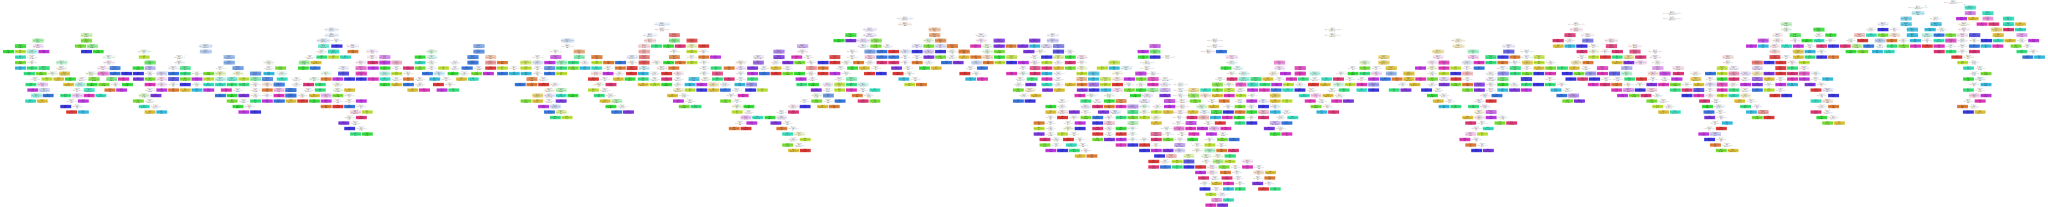

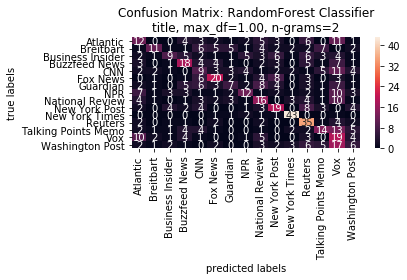

In [115]:
n = 2
classifier = RandomForestClassifier(max_features=None, n_jobs=-1, n_estimators=200)
print('----Random Forest-----')
algorithm_comparison.loc[i, 'algorithm'] = 'RandomForest'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'RandomForest')
    
# show 1 of the decision trees used
est_idx = np.random.randint(0, high=200)
estimator = best_models[i].estimators_[est_idx]
fname = 'RandomForest_i%d_tree%d_%d' % (i, est_idx, samp)
 
graph = Source(export_graphviz(estimator, out_file=None,
               class_names=class_names,
               filled = True))
display(SVG(graph.pipe(format='svg')))
i += 1

In [121]:
algorithm_comparison.head()
print(best_models[4])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


----Random Forest-----
use_title:  title , max_df:  1.0 n-gram:  3
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] criterion=entropy ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................ criterion=entropy, total= 6.8min
[CV] criterion=entropy ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.8min remaining:    0.0s


[CV] ................................ criterion=entropy, total= 7.3min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 7.2min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 6.9min
[CV] criterion=entropy ...............................................
[CV] ................................ criterion=entropy, total= 6.9min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 2.8min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 2.8min
[CV] criterion=gini ..................................................
[CV] ................................... criterion=gini, total= 2.7min
[CV] criterion=gini ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 49.0min finished


Best parameters:  {'criterion': 'gini'}
CV score for each fold (best estimator):  [0.345      0.37666667 0.35333333 0.36833333 0.32833333]
CV score averaged across folds (best estimator):  0.35433333333333333
Training accuracy (best estimator):  1.0
Test accuracy (best estimator):  0.34


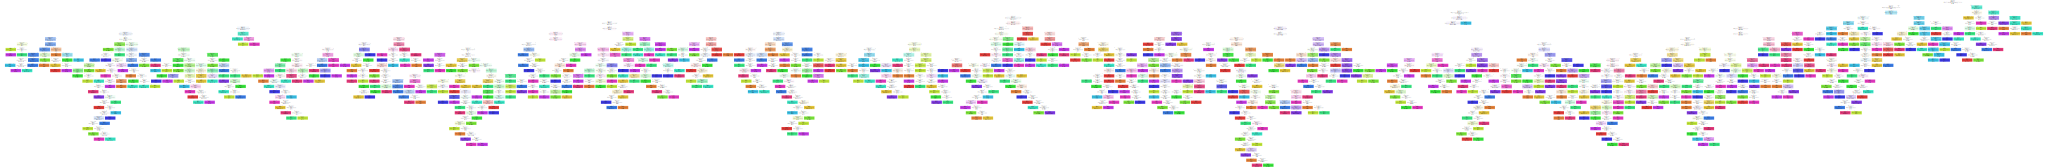

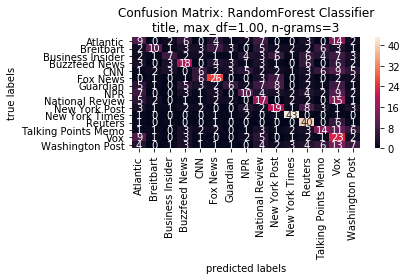

In [122]:
n = 3
classifier = RandomForestClassifier(max_features=None, n_jobs=-1, n_estimators=200)
print('----Random Forest-----')
algorithm_comparison.loc[i, 'algorithm'] = 'RandomForest'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'RandomForest')
    
# show 1 of the decision trees used
est_idx = np.random.randint(0, high=200)
estimator = best_models[i].estimators_[est_idx]
fname = 'RandomForest_i%d_tree%d_%d' % (i, est_idx, samp)
 
graph = Source(export_graphviz(estimator, out_file=None,
               class_names=class_names,
               filled = True))
display(SVG(graph.pipe(format='svg')))
i += 1

In [124]:
algorithm_comparison.head(6)
print(best_models[5])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [125]:
print(cv_results)
algorithm_comparison.head(6)

{'title': [None, None, {'mean_fit_time': array([421.86474614, 165.76813946]), 'std_fit_time': array([11.94450462,  2.88189437]), 'mean_score_time': array([0.11992459, 0.10901942]), 'std_score_time': array([0.00857157, 0.00072806]), 'param_criterion': masked_array(data=['entropy', 'gini'],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'criterion': 'entropy'}, {'criterion': 'gini'}], 'split0_test_score': array([0.32666667, 0.33666667]), 'split1_test_score': array([0.37333333, 0.37166667]), 'split2_test_score': array([0.35333333, 0.37166667]), 'split3_test_score': array([0.345     , 0.37166667]), 'split4_test_score': array([0.33833333, 0.345     ]), 'mean_test_score': array([0.34733333, 0.35933333]), 'std_test_score': array([0.01565602, 0.01533333]), 'rank_test_score': array([2, 1], dtype=int32)}], 'content': [None, None, None]}


algorithm n_train n_test use_title max_df n-gram  cv_score train_acc  \
3  RandomForest    3000    750     title      1      1  0.341333         1   
4  RandomForest    3000    750     title      1      2  0.354333         1   
5  RandomForest    3000    750     title      1      3  0.354333         1   

   test_acc  
3  0.330667  
4  0.333333  
5      0.34

----Random Forest-----
use_title:  title , max_df:  1.0 n-gram:  1
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  16.4s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s remaining:    0.0s


[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  14.0s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  15.3s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  13.4s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  13.6s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=   9.8s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=   9.3s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=   9.5s
[CV] criteri

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 81.9min finished


Best parameters:  {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 0.05}
CV score for each fold (best estimator):  [0.33833333 0.365      0.36666667 0.35833333 0.325     ]
CV score averaged across folds (best estimator):  0.3506666666666667
Training accuracy (best estimator):  0.68
Test accuracy (best estimator):  0.3373333333333333


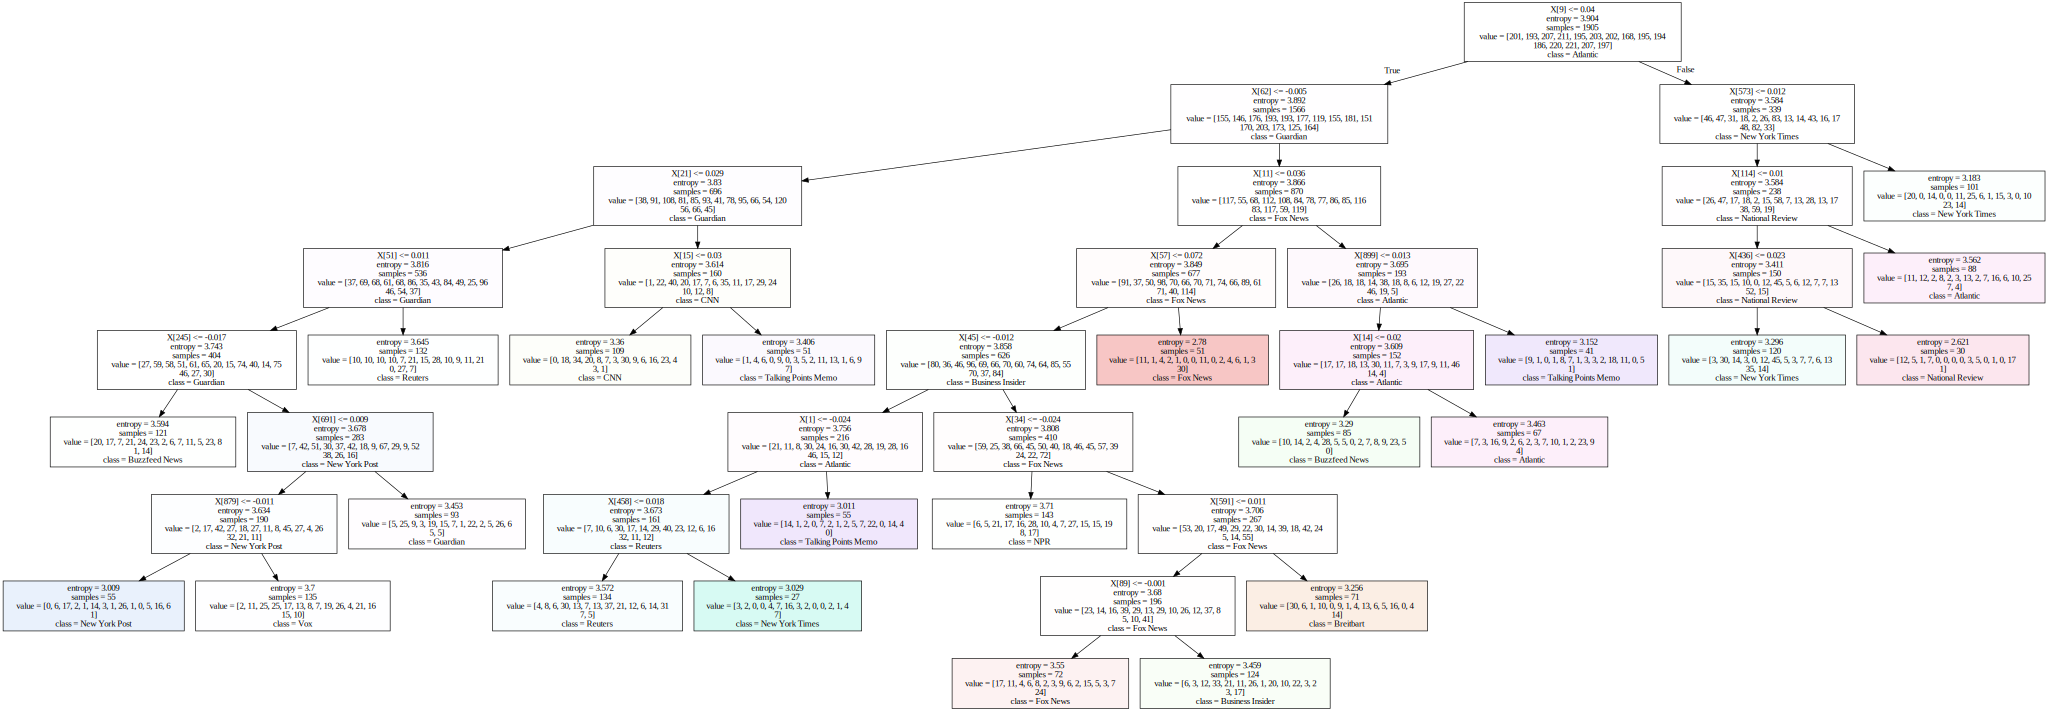

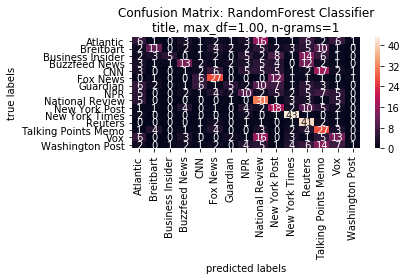

In [126]:
# try other parameters - use sqrt(n) vs n samples with replacement per tree (max_features)
#                      - use min samples to split decision tree (2 vs .05*n_train)
n = 1
params = {'criterion': ['entropy', 'gini'], 'min_samples_split': [2, .05], 'max_features': ['auto', None]}
classifier = RandomForestClassifier(max_features=None, n_jobs=-1, n_estimators=200)
print('----Random Forest-----')
algorithm_comparison.loc[i, 'algorithm'] = 'RandomForest'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'RandomForest')

# show 1 of the decision trees used
est_idx = np.random.randint(0, high=200)
estimator = best_models[i].estimators_[est_idx]
fname = 'RandomForest_i%d_tree%d_%d' % (i, est_idx, samp)
 
graph = Source(export_graphviz(estimator, out_file=None,
               class_names=class_names,
               filled = True))
display(SVG(graph.pipe(format='svg')))
i += 1

In [179]:
cv_results_table = pd.DataFrame(cv_results['title'][2])
cv_results_table.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      15.144393      2.229123         0.128075        0.039729   
1       9.439076      0.244533         0.107290        0.000868   
2     399.881713     10.917164         0.106763        0.001722   
3     290.076585      8.883343         0.109759        0.004441   
4       6.207917      0.278743         0.107767        0.001345   
5       4.030873      0.323433         0.106199        0.001360   
6     160.327225      6.653711         0.127912        0.041317   
7     103.196231      3.202736         0.107017        0.001380   

  param_criterion param_max_features param_min_samples_split  \
0         entropy               auto                       2   
1         entropy               auto                    0.05   
2         entropy               None                       2   
3         entropy               None                    0.05   
4            gini               auto                       2   
5            gini               auto                    0.05   
6            gini               None                       2   
7            gini               None                    0.05   

                                              params  split0_test_score  \
0  {'criterion': 'entropy', 'max_features': 'auto...           0.300000   
1  {'criterion': 'entropy', 'max_features': 'auto...           0.325000   
2  {'criterion': 'entropy', 'max_features': None,...           0.340000   
3  {'criterion': 'entropy', 'max_features': None,...           0.283333   
4  {'criterion': 'gini', 'max_features': 'auto', ...           0.266667   
5  {'criterion': 'gini', 'max_features': 'auto', ...           0.336667   
6  {'criterion': 'gini', 'max_features': None, 'm...           0.326667   
7  {'criterion': 'gini', 'max_features': None, 'm...           0.295000   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.311667           0.330000           0.313333           0.285000   
1           0.360000           0.366667           0.361667           0.341667   
2           0.348333           0.353333           0.336667           0.320000   
3           0.285000           0.286667           0.290000           0.290000   
4           0.353333           0.301667           0.325000           0.288333   
5           0.371667           0.358333           0.356667           0.306667   
6           0.363333           0.338333           0.343333           0.325000   
7           0.315000           0.298333           0.320000           0.280000   

   mean_test_score  std_test_score  rank_test_score  
0         0.308000        0.014959                5  
1         0.351000        0.015513                1  
2         0.339667        0.011470                3  
3         0.287000        0.002667                8  
4         0.307000        0.029915                6  
5         0.346000        0.022623                2  
6         0.339333        0.013848                4  
7         0.301667        0.014414                7

----Random Forest-----
use_title:  title , max_df:  1.0 n-gram:  2
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  16.0s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.0s remaining:    0.0s


[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  14.1s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  14.0s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  13.9s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  15.4s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=   9.8s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=   9.4s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=   9.5s
[CV] criteri

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 83.0min finished


Best parameters:  {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 0.05}
CV score for each fold (best estimator):  [0.335      0.39       0.38333333 0.38166667 0.33666667]
CV score averaged across folds (best estimator):  0.36533333333333334
Training accuracy (best estimator):  0.6786666666666666
Test accuracy (best estimator):  0.3546666666666667


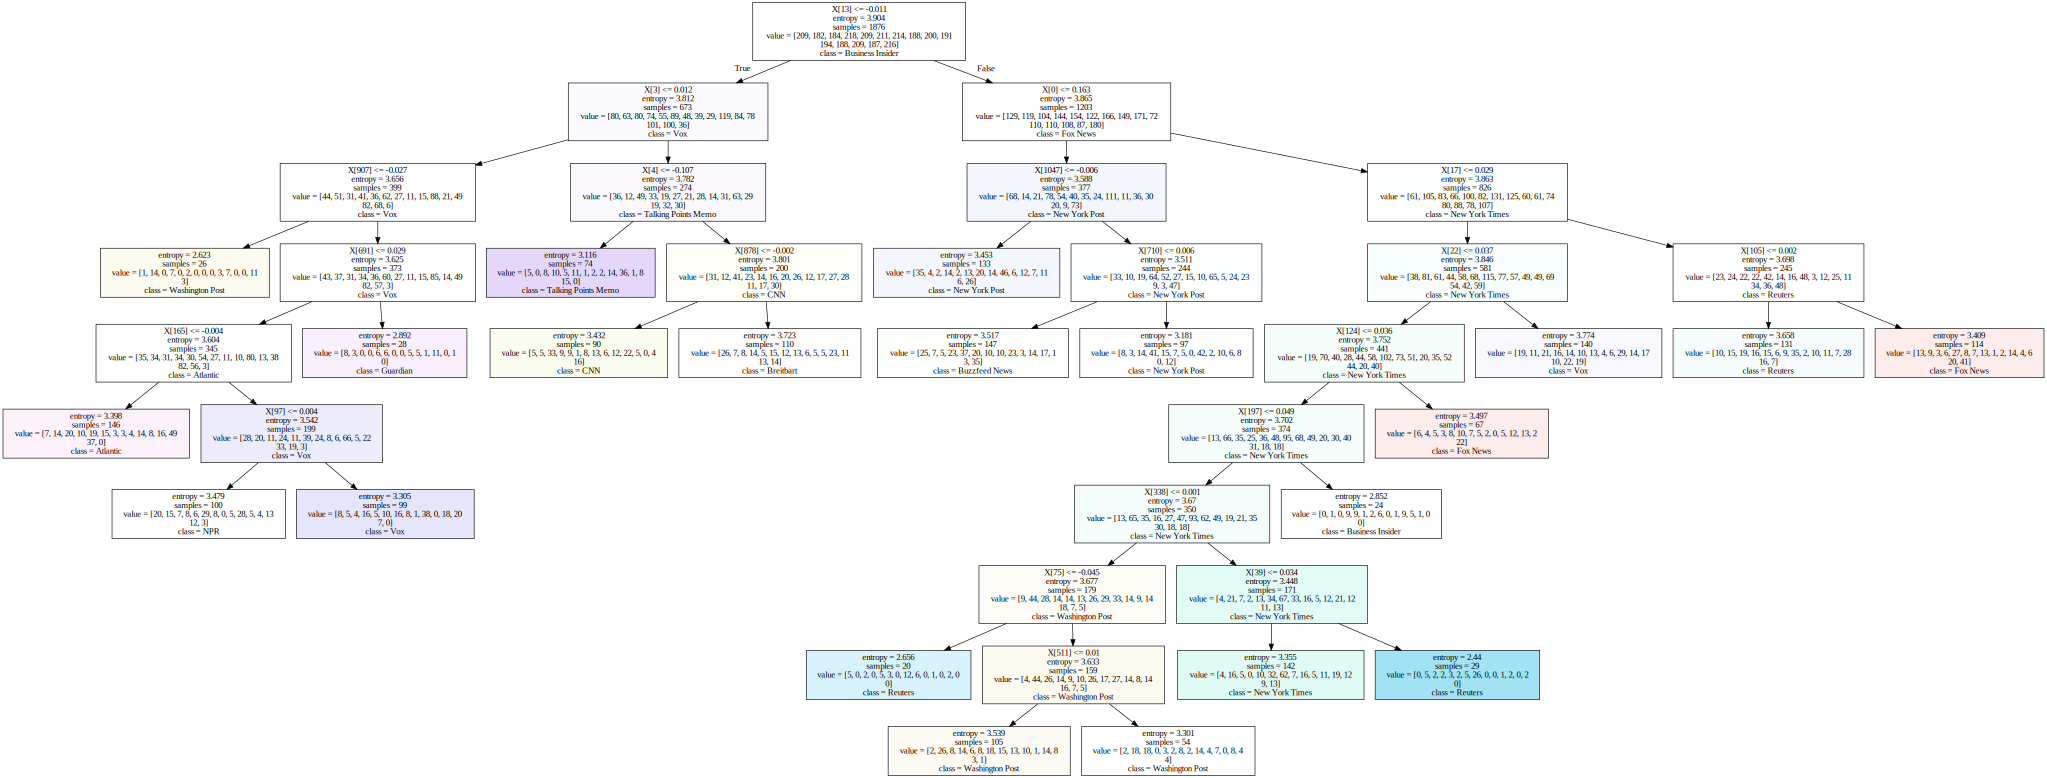

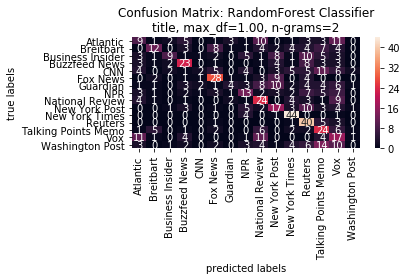

In [128]:
# try other parameters - use sqrt(n) vs n samples with replacement per tree (max_features)
#                      - use min samples to split decision tree (2 vs .05*n_train)
n = 2
params = {'criterion': ['entropy', 'gini'], 'min_samples_split': [2, .05], 'max_features': ['auto', None]}
classifier = RandomForestClassifier(max_features=None, n_jobs=-1, n_estimators=200)
print('----Random Forest-----')
algorithm_comparison.loc[i, 'algorithm'] = 'RandomForest'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'RandomForest')

# show 1 of the decision trees used
est_idx = np.random.randint(0, high=200)
estimator = best_models[i].estimators_[est_idx]
fname = 'RandomForest_i%d_tree%d_%d' % (i, est_idx, samp)
 
graph = Source(export_graphviz(estimator, out_file=None,
               class_names=class_names,
               filled = True))
display(SVG(graph.pipe(format='svg')))
i += 1

In [129]:
algorithm_comparison.head(6)

algorithm n_train n_test use_title max_df n-gram  cv_score train_acc  \
3  RandomForest    3000    750     title      1      1  0.341333         1   
4  RandomForest    3000    750     title      1      2  0.354333         1   
5  RandomForest    3000    750     title      1      3  0.354333         1   
6  RandomForest    3000    750     title      1      1  0.350667      0.68   
7  RandomForest    3000    750     title      1      2  0.365333  0.678667   

   test_acc  
3  0.330667  
4  0.333333  
5      0.34  
6  0.337333  
7  0.354667

----Random Forest-----
use_title:  title , max_df:  1.0 n-gram:  3
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  19.3s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.3s remaining:    0.0s


[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  18.1s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  21.5s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  19.5s
[CV] criterion=entropy, max_features=auto, min_samples_split=2 .......
[CV]  criterion=entropy, max_features=auto, min_samples_split=2, total=  15.0s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=  10.4s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=  10.7s
[CV] criterion=entropy, max_features=auto, min_samples_split=0.05 ....
[CV]  criterion=entropy, max_features=auto, min_samples_split=0.05, total=   9.9s
[CV] criteri

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 90.0min finished


Best parameters:  {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_split': 0.05}
CV score for each fold (best estimator):  [0.34666667 0.39833333 0.37833333 0.375      0.32666667]
CV score averaged across folds (best estimator):  0.365
Training accuracy (best estimator):  0.6716666666666666
Test accuracy (best estimator):  0.36


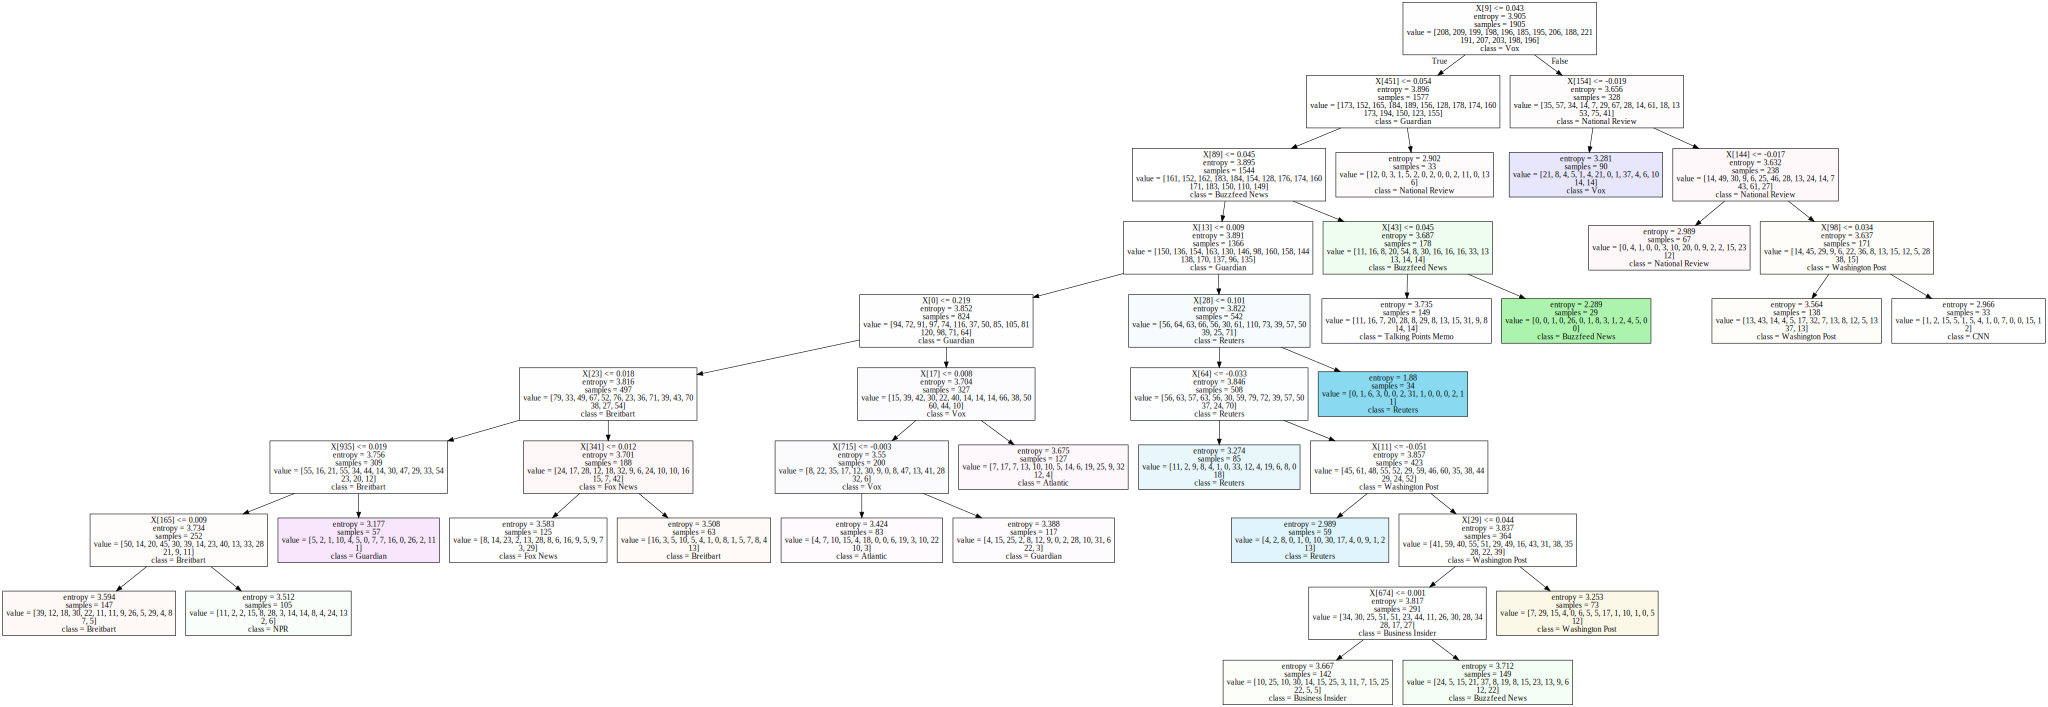

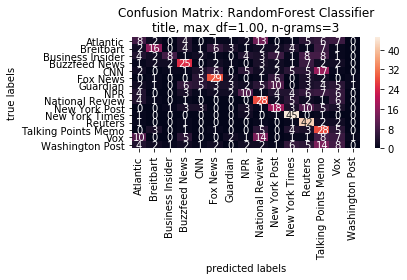

In [131]:
# try other parameters - use sqrt(n) vs n samples with replacement per tree (max_features)
#                      - use min samples to split decision tree (2 vs .05*n_train)
n = 3
params = {'criterion': ['entropy', 'gini'], 'min_samples_split': [2, .05], 'max_features': ['auto', None]}
classifier = RandomForestClassifier(max_features=None, n_jobs=-1, n_estimators=200)
print('----Random Forest-----')
algorithm_comparison.loc[i, 'algorithm'] = 'RandomForest'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'RandomForest')

# show 1 of the decision trees used
est_idx = np.random.randint(0, high=200)
estimator = best_models[i].estimators_[est_idx]
fname = 'RandomForest_i%d_tree%d_%d' % (i, est_idx, samp)
 
graph = Source(export_graphviz(estimator, out_file=None,
               class_names=class_names,
               filled = True))
display(SVG(graph.pipe(format='svg')))
i += 1

In [132]:
algorithm_comparison.head(10)

algorithm n_train n_test use_title max_df n-gram  cv_score train_acc  \
3  RandomForest    3000    750     title      1      1  0.341333         1   
4  RandomForest    3000    750     title      1      2  0.354333         1   
5  RandomForest    3000    750     title      1      3  0.354333         1   
6  RandomForest    3000    750     title      1      1  0.350667      0.68   
7  RandomForest    3000    750     title      1      2  0.365333  0.678667   
8  RandomForest    3000    750     title      1      3     0.365  0.671667   

   test_acc  
3  0.330667  
4  0.333333  
5      0.34  
6  0.337333  
7  0.354667  
8      0.36

In [133]:
#print(y_train['title'])
#print(np.max(y_train['title']))
#print(np.array(y_train['title']) == 1)
class_frequencies = [np.sum(np.array(y_train['title']) == i) for i in range(np.max(y_train['title']))]
print('class frequencies: ', class_frequencies)
class_frequencies_test = [np.sum(np.array(y_test['title']) == i) for i in range(np.max(y_test['title']))]
print(class_frequencies_test)

class frequencies:  [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200]
[50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50]


----Support Vector Machine-----
use_title:  title , max_df:  1.0 n-gram:  1
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.1, kernel=linear, total=  13.8s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


[CV] ............................. C=0.1, kernel=linear, total=  16.5s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  13.0s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  12.9s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  12.8s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  11.7s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  14.7s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  11.6s
[CV] C=1, kernel=linear ..............................................
[CV] .

[CV] ................... C=10, gamma=0.0001, kernel=rbf, total=  13.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  13.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  14.6s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  15.7s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  13.7s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  13.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  12.5s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 16.6min finished


Best parameters:  {'C': 1, 'kernel': 'linear'}
CV score for each fold (best estimator):  [0.46166667 0.48333333 0.44666667 0.46166667 0.46166667]
CV score averaged across folds (best estimator):  0.46299999999999997
Training accuracy (best estimator):  0.8553333333333333
Test accuracy (best estimator):  0.46266666666666667


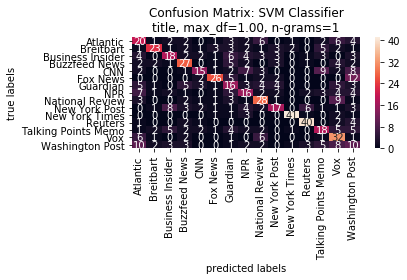

In [134]:
from sklearn.svm import SVC

n = 1
params = [{'kernel' : ['linear'], 'C': [1e-1, 1, 10]}, 
          {'kernel' : ['rbf'], 'C': [1e-1, 1, 10], 'gamma' : [1e-4, 1e-3, 1e-2, 1e-1]}]
classifier = SVC()
print('----Support Vector Machine-----')
algorithm_comparison.loc[i, 'algorithm'] = 'SVM'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'SVM')
i += 1

----Support Vector Machine-----
use_title:  title , max_df:  1.0 n-gram:  2
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.1, kernel=linear, total=  14.1s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s


[CV] ............................. C=0.1, kernel=linear, total=  13.6s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  13.5s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  13.6s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  13.5s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  13.3s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  12.5s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  12.2s
[CV] C=1, kernel=linear ..............................................
[CV] .

[CV] ................... C=10, gamma=0.0001, kernel=rbf, total=  15.7s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  13.9s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  14.6s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  14.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  14.4s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  17.7s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  13.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 18.4min finished


Best parameters:  {'C': 1, 'kernel': 'linear'}
CV score for each fold (best estimator):  [0.49333333 0.49666667 0.48666667 0.475      0.48      ]
CV score averaged across folds (best estimator):  0.48633333333333334
Training accuracy (best estimator):  0.877
Test accuracy (best estimator):  0.48


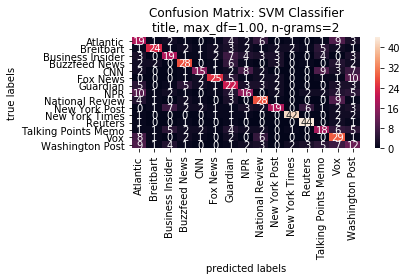

In [135]:
n = 2
params = [{'kernel' : ['linear'], 'C': [1e-1, 1, 10]}, 
          {'kernel' : ['rbf'], 'C': [1e-1, 1, 10], 'gamma' : [1e-4, 1e-3, 1e-2, 1e-1]}]
classifier = SVC()
print('----Support Vector Machine-----')
algorithm_comparison.loc[i, 'algorithm'] = 'SVM'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'SVM')
i += 1

In [137]:
algorithm_comparison.head(10)
print(best_models[9])

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


----Support Vector Machine-----
use_title:  title , max_df:  1.0 n-gram:  3
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.1, kernel=linear, total=  15.0s
[CV] C=0.1, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.0s remaining:    0.0s


[CV] ............................. C=0.1, kernel=linear, total=  13.9s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  14.9s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  16.1s
[CV] C=0.1, kernel=linear ............................................
[CV] ............................. C=0.1, kernel=linear, total=  14.4s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  14.7s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  15.2s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  12.6s
[CV] C=1, kernel=linear ..............................................
[CV] .

[CV] ................... C=10, gamma=0.0001, kernel=rbf, total=  15.7s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  14.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  14.2s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  14.8s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  15.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .................... C=10, gamma=0.001, kernel=rbf, total=  15.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  14.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 18.0min finished


Best parameters:  {'C': 1, 'kernel': 'linear'}
CV score for each fold (best estimator):  [0.49       0.495      0.48833333 0.48666667 0.475     ]
CV score averaged across folds (best estimator):  0.487
Training accuracy (best estimator):  0.8766666666666667
Test accuracy (best estimator):  0.48


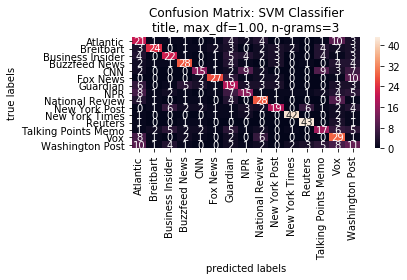

In [138]:
n = 3
params = [{'kernel' : ['linear'], 'C': [1e-1, 1, 10]}, 
          {'kernel' : ['rbf'], 'C': [1e-1, 1, 10], 'gamma' : [1e-4, 1e-3, 1e-2, 1e-1]}]
classifier = SVC()
print('----Support Vector Machine-----')
algorithm_comparison.loc[i, 'algorithm'] = 'SVM'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'SVM')
i += 1

In [139]:
cv_results_table = pd.DataFrame(cv_results['title'][2])
cv_results_table.head(15)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       12.930067      0.848218         1.932842        0.281428     0.1   
1       11.646740      1.346071         1.623800        0.124079       1   
2       10.929764      0.016956         1.555400        0.017113      10   
3       13.458355      0.622107         2.026800        0.243556     0.1   
4       12.414891      0.168404         1.684222        0.015144     0.1   
5       13.209025      0.634332         1.797507        0.161003     0.1   
6       13.079537      0.946526         1.698655        0.047738     0.1   
7       13.271609      0.637192         1.750580        0.021720       1   
8       13.363847      0.929933         1.757895        0.166230       1   
9       12.763207      0.388394         1.715824        0.094365       1   
10      11.982867      0.129982         1.688109        0.088977       1   
11      13.635136      0.585324         1.886839        0.188113      10   
12      12.902380      0.359432         1.761162        0.080785      10   
13      12.241670      0.595224         1.766875        0.163205      10   
14      11.662367      0.384282         1.622184        0.042053      10   

   param_kernel param_gamma                                        params  \
0        linear         NaN                {'C': 0.1, 'kernel': 'linear'}   
1        linear         NaN                  {'C': 1, 'kernel': 'linear'}   
2        linear         NaN                 {'C': 10, 'kernel': 'linear'}   
3           rbf      0.0001  {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}   
4           rbf       0.001   {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}   
5           rbf        0.01    {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}   
6           rbf         0.1     {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}   
7           rbf      0.0001    {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}   
8           rbf       0.001     {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}   
9           rbf        0.01      {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}   
10          rbf         0.1       {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}   
11          rbf      0.0001   {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}   
12          rbf       0.001    {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}   
13          rbf        0.01     {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}   
14          rbf         0.1      {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}   

    split0_test_score  split1_test_score  split2_test_score  \
0            0.335000           0.408333           0.351667   
1            0.490000           0.495000           0.488333   
2            0.488333           0.475000           0.495000   
3            0.325000           0.405000           0.348333   
4            0.325000           0.405000           0.348333   
5            0.325000           0.405000           0.348333   
6            0.325000           0.408333           0.348333   
7            0.325000           0.405000           0.348333   
8            0.325000           0.405000           0.348333   
9            0.325000           0.405000           0.348333   
10           0.368333           0.443333           0.368333   
11           0.325000           0.405000           0.348333   
12           0.325000           0.405000           0.348333   
13           0.388333           0.455000           0.381667   
14           0.483333           0.485000           0.488333   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0            0.380000           0.321667         0.359333        0.031298   
1            0.486667           0.475000         0.487000        0.006616   
2            0.466667           0.460000         0.477000        0.013055   
3            0.373333           0.318333         0.354000        0.032000   
4            0.375000           0.318333         0.354333        0.032208   
5            0.375000           0.318333         0.354333        0.032208   
6     

----Support Vector Machine-----
use_title:  title , max_df:  1.0 n-gram:  1
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=1, kernel=linear, total=  12.8s
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.8s remaining:    0.0s


[CV] ............................... C=1, kernel=linear, total=  11.8s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  11.2s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  11.1s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  11.0s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  11.8s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  11.8s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  11.7s
[CV] C=2, kernel=linear ..............................................
[CV] .

[CV] ...................... C=20, gamma=0.1, kernel=rbf, total=  12.3s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  13.5s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  13.1s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  13.1s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  13.1s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  13.2s


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed: 13.2min finished


Best parameters:  {'C': 2, 'kernel': 'linear'}
CV score for each fold (best estimator):  [0.45666667 0.47833333 0.475      0.465      0.45833333]
CV score averaged across folds (best estimator):  0.4666666666666667
Training accuracy (best estimator):  0.9326666666666666
Test accuracy (best estimator):  0.456


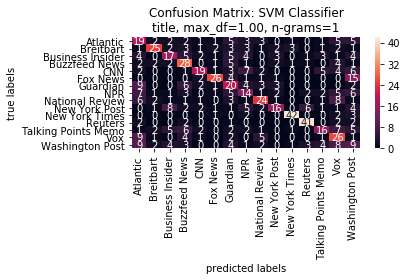

In [140]:
n = 1
params = [{'kernel' : ['linear'], 'C': [1, 2, 5, 10]}, 
          {'kernel' : ['rbf'], 'C': [5, 10, 20], 'gamma' : [5e-2, 1e-1, 1]}]
classifier = SVC()
print('----Support Vector Machine-----')
algorithm_comparison.loc[i, 'algorithm'] = 'SVM'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'SVM')
i += 1

----Support Vector Machine-----
use_title:  title , max_df:  1.0 n-gram:  2
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=1, kernel=linear, total=  12.2s
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.2s remaining:    0.0s


[CV] ............................... C=1, kernel=linear, total=  11.9s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  11.9s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  12.7s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  13.0s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  14.7s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  13.1s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  12.5s
[CV] C=2, kernel=linear ..............................................
[CV] .

[CV] ...................... C=20, gamma=0.1, kernel=rbf, total=  14.0s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  14.2s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  14.3s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  15.5s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  14.7s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  14.4s


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed: 14.5min finished


Best parameters:  {'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}
CV score for each fold (best estimator):  [0.49833333 0.49666667 0.485      0.48       0.48166667]
CV score averaged across folds (best estimator):  0.4883333333333333
Training accuracy (best estimator):  0.8793333333333333
Test accuracy (best estimator):  0.47733333333333333


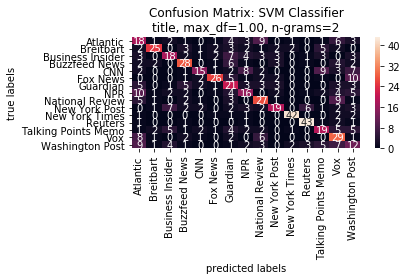

In [141]:
n = 2
params = [{'kernel' : ['linear'], 'C': [1, 2, 5, 10]}, 
          {'kernel' : ['rbf'], 'C': [5, 10, 20], 'gamma' : [5e-2, 1e-1, 1]}]
classifier = SVC()
print('----Support Vector Machine-----')
algorithm_comparison.loc[i, 'algorithm'] = 'SVM'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'SVM')
i += 1

In [198]:
cv_results_table = pd.DataFrame(cv_results['title'][2])
cv_results_table.head(15)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       10.962164      1.899112         1.796550        0.391193       1   
1       10.278743      0.644620         1.427817        0.007113       2   
2       12.415118      1.673009         1.680991        0.308198       5   
3       10.102228      0.289323         1.451897        0.045478      10   
4       10.690036      0.651324         1.549457        0.098243       5   
5        9.974354      0.622389         1.491086        0.020249       5   
6       11.645516      0.691682         1.557099        0.027367       5   
7        9.737890      0.284963         1.475740        0.045945      10   
8       10.293081      0.136632         1.444221        0.020708      10   
9       11.172995      0.252180         1.545518        0.018555      10   
10      10.309876      0.104007         1.467803        0.026417      20   
11      10.771947      0.786589         1.488003        0.048449      20   
12      11.820706      0.735048         1.593003        0.079671      20   

   param_kernel param_gamma                                     params  \
0        linear         NaN               {'C': 1, 'kernel': 'linear'}   
1        linear         NaN               {'C': 2, 'kernel': 'linear'}   
2        linear         NaN               {'C': 5, 'kernel': 'linear'}   
3        linear         NaN              {'C': 10, 'kernel': 'linear'}   
4           rbf        0.05   {'C': 5, 'gamma': 0.05, 'kernel': 'rbf'}   
5           rbf         0.1    {'C': 5, 'gamma': 0.1, 'kernel': 'rbf'}   
6           rbf           1      {'C': 5, 'gamma': 1, 'kernel': 'rbf'}   
7           rbf        0.05  {'C': 10, 'gamma': 0.05, 'kernel': 'rbf'}   
8           rbf         0.1   {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}   
9           rbf           1     {'C': 10, 'gamma': 1, 'kernel': 'rbf'}   
10          rbf        0.05  {'C': 20, 'gamma': 0.05, 'kernel': 'rbf'}   
11          rbf         0.1   {'C': 20, 'gamma': 0.1, 'kernel': 'rbf'}   
12          rbf           1     {'C': 20, 'gamma': 1, 'kernel': 'rbf'}   

    split0_test_score  split1_test_score  split2_test_score  \
0            0.465000           0.486667           0.455000   
1            0.451667           0.470000           0.465000   
2            0.450000           0.463333           0.475000   
3            0.460000           0.461667           0.476667   
4            0.426667           0.475000           0.428333   
5            0.466667           0.490000           0.450000   
6            0.435000           0.461667           0.453333   
7            0.465000           0.485000           0.448333   
8            0.456667           0.478333           0.470000   
9            0.436667           0.463333           0.458333   
10           0.453333           0.478333           0.466667   
11           0.460000           0.475000           0.470000   
12           0.438333           0.463333           0.456667   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0            0.456667           0.455000         0.463667        0.012083   
1            0.473333           0.458333         0.463667        0.007846   
2            0.465000           0.460000         0.462667        0.008069   
3            0.470000           0.455000         0.464667        0.007703   
4            0.443333           0.416667         0.438000        0.020369   
5            0.463333           0.445000         0.463000        0.015720   
6            0.461667           0.441667         0.450667        0.010729   
7            0.463333           0.446667         0.461667        0.013864   
8            0.478333           0.458333         0.468333        0.009369   
9            0.461667           0.441667         0.452333        0.010985   
10           0.471667           0.460000         0.466000        0.008731   
11           0.461667           0.453333         0.464000        0.007645   
12           0.463

----Support Vector Machine-----
use_title:  title , max_df:  1.0 n-gram:  3
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=1, kernel=linear, total=  13.2s
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s remaining:    0.0s


[CV] ............................... C=1, kernel=linear, total=  13.1s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  12.3s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  12.3s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=  12.1s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  13.2s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  13.1s
[CV] C=2, kernel=linear ..............................................
[CV] ............................... C=2, kernel=linear, total=  12.7s
[CV] C=2, kernel=linear ..............................................
[CV] .

[CV] ...................... C=20, gamma=0.1, kernel=rbf, total=  18.7s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  14.3s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  14.6s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  16.5s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  14.1s
[CV] C=20, gamma=1, kernel=rbf .......................................
[CV] ........................ C=20, gamma=1, kernel=rbf, total=  14.8s


[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed: 15.3min finished


Best parameters:  {'C': 1, 'kernel': 'linear'}
CV score for each fold (best estimator):  [0.49       0.495      0.48833333 0.48666667 0.475     ]
CV score averaged across folds (best estimator):  0.487
Training accuracy (best estimator):  0.8766666666666667
Test accuracy (best estimator):  0.48


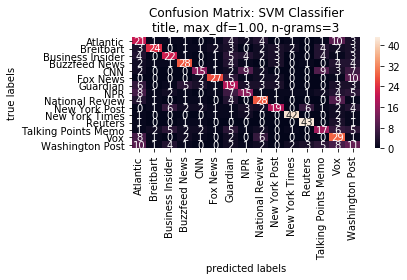

In [142]:
n = 3
params = [{'kernel' : ['linear'], 'C': [1, 2, 5, 10]}, 
          {'kernel' : ['rbf'], 'C': [5, 10, 20], 'gamma' : [5e-2, 1e-1, 1]}]
classifier = SVC()
print('----Support Vector Machine-----')
algorithm_comparison.loc[i, 'algorithm'] = 'SVM'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'SVM')
i += 1

In [199]:
params = {'kernel' : ['rbf'], 'C': [8, 10, 12, 15], 'gamma' : [8e-2, 1e-1, 2e-1, 5e-1]}
classifier = SVC()
print('----Support Vector Machine-----')
algorithm_comparison.loc[i, 'algorithm'] = 'SVM'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, 2, i)
i += 1

----Support Vector Machine-----
use_title:  title , max_df:  1.0
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=8, gamma=0.08, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=8, gamma=0.08, kernel=rbf, total=  11.8s
[CV] C=8, gamma=0.08, kernel=rbf .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.8s remaining:    0.0s


[CV] ...................... C=8, gamma=0.08, kernel=rbf, total=  11.6s
[CV] C=8, gamma=0.08, kernel=rbf .....................................
[CV] ...................... C=8, gamma=0.08, kernel=rbf, total=  12.1s
[CV] C=8, gamma=0.08, kernel=rbf .....................................
[CV] ...................... C=8, gamma=0.08, kernel=rbf, total=  11.9s
[CV] C=8, gamma=0.08, kernel=rbf .....................................
[CV] ...................... C=8, gamma=0.08, kernel=rbf, total=  11.6s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=8, gamma=0.1, kernel=rbf, total=  12.0s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=8, gamma=0.1, kernel=rbf, total=  11.8s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=8, gamma=0.1, kernel=rbf, total=  11.8s
[CV] C=8, gamma=0.1, kernel=rbf ......................................
[CV] .

[CV] ...................... C=12, gamma=0.5, kernel=rbf, total=  12.3s
[CV] C=15, gamma=0.08, kernel=rbf ....................................
[CV] ..................... C=15, gamma=0.08, kernel=rbf, total=  11.7s
[CV] C=15, gamma=0.08, kernel=rbf ....................................
[CV] ..................... C=15, gamma=0.08, kernel=rbf, total=  11.8s
[CV] C=15, gamma=0.08, kernel=rbf ....................................
[CV] ..................... C=15, gamma=0.08, kernel=rbf, total=  11.7s
[CV] C=15, gamma=0.08, kernel=rbf ....................................
[CV] ..................... C=15, gamma=0.08, kernel=rbf, total=  15.6s
[CV] C=15, gamma=0.08, kernel=rbf ....................................
[CV] ..................... C=15, gamma=0.08, kernel=rbf, total=  11.8s
[CV] C=15, gamma=0.1, kernel=rbf .....................................
[CV] ...................... C=15, gamma=0.1, kernel=rbf, total=  12.2s
[CV] C=15, gamma=0.1, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 16.3min finished


Best parameters:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
CV score for each fold (best estimator):  [0.45666667 0.47833333 0.47       0.47833333 0.45833333]
CV score averaged across folds (best estimator):  0.4683333333333334
Training accuracy (best estimator):  0.939
Test accuracy (best estimator):  0.476


In [201]:
cv_results_table = pd.DataFrame(cv_results['title'][2])
cv_results_table.head(16)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       10.319890      0.172071         1.475496        0.023569       8   
1       10.419829      0.115479         1.554075        0.151192       8   
2       10.896429      0.535251         1.512668        0.077884       8   
3       11.638259      0.783711         1.533653        0.027578       8   
4       10.289085      0.104853         1.474953        0.015511      10   
5       10.496016      0.192512         1.482595        0.012889      10   
6       11.015642      0.923417         1.474927        0.043820      10   
7       11.106971      0.605930         1.493708        0.024272      10   
8       10.280615      0.130879         1.452214        0.019096      12   
9       10.625291      0.315965         1.492050        0.038304      12   
10      10.727392      0.207798         1.465746        0.020563      12   
11      10.838334      0.138512         1.494905        0.016758      12   
12      11.036849      1.514841         1.461173        0.032808      15   
13      10.582231      0.303980         1.473365        0.034898      15   
14      10.498319      0.113638         1.462220        0.011064      15   
15      10.965985      0.214939         1.513687        0.013311      15   

   param_gamma param_kernel                                     params  \
0         0.08          rbf   {'C': 8, 'gamma': 0.08, 'kernel': 'rbf'}   
1          0.1          rbf    {'C': 8, 'gamma': 0.1, 'kernel': 'rbf'}   
2          0.2          rbf    {'C': 8, 'gamma': 0.2, 'kernel': 'rbf'}   
3          0.5          rbf    {'C': 8, 'gamma': 0.5, 'kernel': 'rbf'}   
4         0.08          rbf  {'C': 10, 'gamma': 0.08, 'kernel': 'rbf'}   
5          0.1          rbf   {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}   
6          0.2          rbf   {'C': 10, 'gamma': 0.2, 'kernel': 'rbf'}   
7          0.5          rbf   {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}   
8         0.08          rbf  {'C': 12, 'gamma': 0.08, 'kernel': 'rbf'}   
9          0.1          rbf   {'C': 12, 'gamma': 0.1, 'kernel': 'rbf'}   
10         0.2          rbf   {'C': 12, 'gamma': 0.2, 'kernel': 'rbf'}   
11         0.5          rbf   {'C': 12, 'gamma': 0.5, 'kernel': 'rbf'}   
12        0.08          rbf  {'C': 15, 'gamma': 0.08, 'kernel': 'rbf'}   
13         0.1          rbf   {'C': 15, 'gamma': 0.1, 'kernel': 'rbf'}   
14         0.2          rbf   {'C': 15, 'gamma': 0.2, 'kernel': 'rbf'}   
15         0.5          rbf   {'C': 15, 'gamma': 0.5, 'kernel': 'rbf'}   

    split0_test_score  split1_test_score  split2_test_score  \
0            0.465000           0.470000           0.460000   
1            0.460000           0.461667           0.463333   
2            0.458333           0.475000           0.463333   
3            0.446667           0.481667           0.468333   
4            0.456667           0.465000           0.461667   
5            0.456667           0.478333           0.470000   
6            0.453333           0.475000           0.466667   
7            0.443333           0.481667           0.473333   
8            0.456667           0.476667           0.470000   
9            0.456667           0.460000           0.470000   
10           0.453333           0.473333           0.473333   
11           0.441667           0.480000           0.475000   
12           0.453333           0.461667           0.471667   
13           0.456667           0.473333           0.466667   
14           0.458333           0.465000           0.473333   
15           0.440000           0.480000           0.475000   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0            0.465000           0.450000         0.462000        0.006782   
1            0.461667           0.456667         0.460667        0.002261   
2            0.463333           0.451667         0.462333        0.007645   
3            0.463333           0.443333         0.460667        0.01416

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  1
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.5, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... C=0.5, solver=newton-cg, total=   1.1s
[CV] C=0.5, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .......................... C=0.5, solver=newton-cg, total=   0.9s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   0.8s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   0.8s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   0.8s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   3.3s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   3.2s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   3.2s
[CV] C=0.5, solver=sag ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.9min finished


Best parameters:  {'C': 10, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.47166667 0.505      0.49833333 0.48833333 0.47666667]
CV score averaged across folds (best estimator):  0.488
Training accuracy (best estimator):  0.9816666666666667
Test accuracy (best estimator):  0.4866666666666667


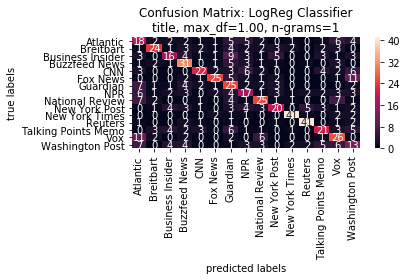

In [143]:
from sklearn.linear_model import LogisticRegression

n = 1
params = {'solver' : ['newton-cg', 'sag'], 'C': [5e-1, 1, 10, 50]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  2
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.5, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... C=0.5, solver=newton-cg, total=   1.1s
[CV] C=0.5, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .......................... C=0.5, solver=newton-cg, total=   0.9s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   0.7s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   0.9s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   0.8s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   4.0s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   4.4s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   4.0s
[CV] C=0.5, solver=sag ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.1min finished


Best parameters:  {'C': 10, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.505      0.51833333 0.53166667 0.50333333 0.50833333]
CV score averaged across folds (best estimator):  0.5133333333333334
Training accuracy (best estimator):  0.9853333333333333
Test accuracy (best estimator):  0.516


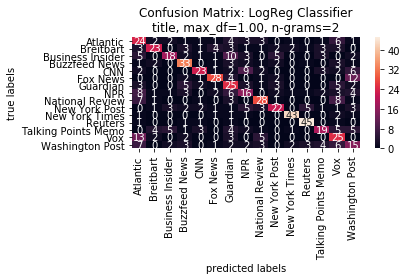

In [144]:
from sklearn.linear_model import LogisticRegression

n = 2
params = {'solver' : ['newton-cg', 'sag'], 'C': [5e-1, 1, 10, 50]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  3
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=0.5, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... C=0.5, solver=newton-cg, total=   1.2s
[CV] C=0.5, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] .......................... C=0.5, solver=newton-cg, total=   1.0s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   1.2s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   1.1s
[CV] C=0.5, solver=newton-cg .........................................
[CV] .......................... C=0.5, solver=newton-cg, total=   0.8s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   3.8s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   3.9s
[CV] C=0.5, solver=sag ...............................................
[CV] ................................ C=0.5, solver=sag, total=   3.1s
[CV] C=0.5, solver=sag ...............................................
[CV] .

/Users/katiebanas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.0min finished


[CV] ................................. C=50, solver=sag, total=  15.5s
Best parameters:  {'C': 10, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.51833333 0.53       0.53166667 0.50333333 0.51      ]
CV score averaged across folds (best estimator):  0.5186666666666667
Training accuracy (best estimator):  0.9883333333333333
Test accuracy (best estimator):  0.5173333333333333


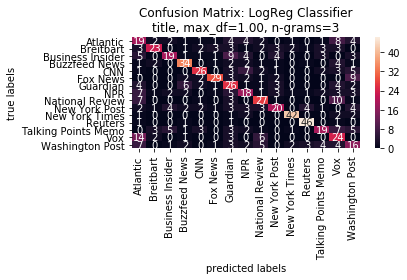

In [145]:
n = 3
params = {'solver' : ['newton-cg', 'sag'], 'C': [5e-1, 1, 10, 50]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  1
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=5, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=5, solver=newton-cg, total=   1.8s
[CV] C=5, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ............................ C=5, solver=newton-cg, total=   1.3s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.3s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.1s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.6s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   6.5s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   6.9s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   6.3s
[CV] C=5, solver=sag .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.7min finished


Best parameters:  {'C': 5, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.47833333 0.51333333 0.495      0.49       0.47      ]
CV score averaged across folds (best estimator):  0.48933333333333334
Training accuracy (best estimator):  0.947
Test accuracy (best estimator):  0.49066666666666664


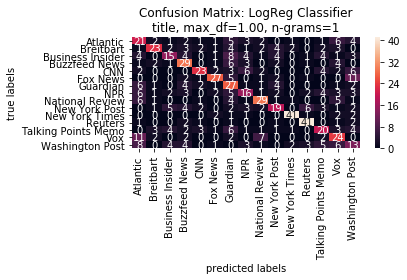

In [146]:
n = 1
params = {'solver' : ['newton-cg', 'sag'], 'C': [5, 10, 15, 25]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  2
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=5, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=5, solver=newton-cg, total=   1.7s
[CV] C=5, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] ............................ C=5, solver=newton-cg, total=   1.8s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.6s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.4s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.4s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   7.7s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   7.5s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   7.1s
[CV] C=5, solver=sag .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.7min finished


Best parameters:  {'C': 5, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.51333333 0.54166667 0.52166667 0.50166667 0.51      ]
CV score averaged across folds (best estimator):  0.5176666666666666
Training accuracy (best estimator):  0.9586666666666667
Test accuracy (best estimator):  0.5133333333333333


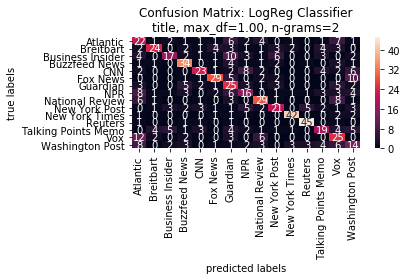

In [147]:
n = 2
params = {'solver' : ['newton-cg', 'sag'], 'C': [5, 10, 15, 25]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  3
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] C=5, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=5, solver=newton-cg, total=   1.8s
[CV] C=5, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] ............................ C=5, solver=newton-cg, total=   2.0s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.5s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   1.9s
[CV] C=5, solver=newton-cg ...........................................
[CV] ............................ C=5, solver=newton-cg, total=   3.3s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   7.5s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   7.4s
[CV] C=5, solver=sag .................................................
[CV] .................................. C=5, solver=sag, total=   6.8s
[CV] C=5, solver=sag .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.7min finished


Best parameters:  {'C': 5, 'solver': 'sag'}
CV score for each fold (best estimator):  [0.52       0.53666667 0.52833333 0.51166667 0.50833333]
CV score averaged across folds (best estimator):  0.521
Training accuracy (best estimator):  0.9593333333333334
Test accuracy (best estimator):  0.524


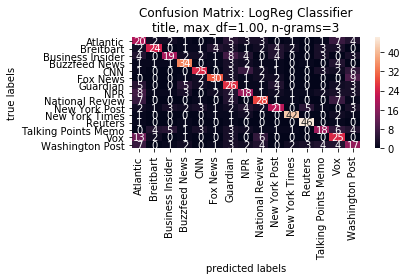

In [148]:
n = 3
params = {'solver' : ['newton-cg', 'sag'], 'C': [5, 10, 15, 25]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n,2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  1
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] C=3, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=3, solver=newton-cg, total=   1.6s
[CV] C=3, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ............................ C=3, solver=newton-cg, total=   1.1s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.2s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.1s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.4s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.8s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.2s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.4s
[CV] C=3, solver=sag .................................................
[CV] .

[CV] .................................. C=8, solver=sag, total=   8.4s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.2s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.3s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.4s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.4s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.4s
[CV] C=9, solver=sag .................................................
[CV] .................................. C=9, solver=sag, total=   8.6s
[CV] C=9, solver=sag .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  4.9min finished


Best parameters:  {'C': 3, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.48       0.51666667 0.49166667 0.49166667 0.47      ]
CV score averaged across folds (best estimator):  0.49000000000000005
Training accuracy (best estimator):  0.9166666666666666
Test accuracy (best estimator):  0.488


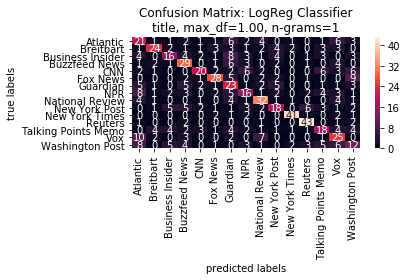

In [149]:
n = 1
params = {'solver' : ['newton-cg', 'sag'], 'C': [3, 4, 5, 6, 7, 8, 9]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  2
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] C=3, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=3, solver=newton-cg, total=   1.4s
[CV] C=3, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ............................ C=3, solver=newton-cg, total=   1.6s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.3s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.2s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.2s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.4s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.0s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.9s
[CV] C=3, solver=sag .................................................
[CV] .

[CV] .................................. C=8, solver=sag, total=  10.3s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.6s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   2.5s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   2.4s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.7s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.8s
[CV] C=9, solver=sag .................................................
[CV] .................................. C=9, solver=sag, total=  10.1s
[CV] C=9, solver=sag .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  5.3min finished


Best parameters:  {'C': 3, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.51166667 0.55166667 0.51833333 0.51833333 0.5       ]
CV score averaged across folds (best estimator):  0.52
Training accuracy (best estimator):  0.93
Test accuracy (best estimator):  0.5066666666666667


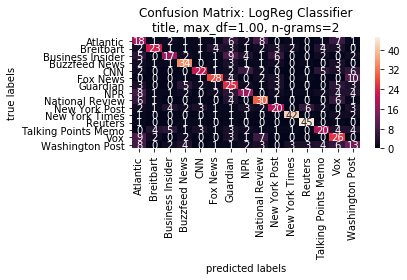

In [150]:
n = 2
params = {'solver' : ['newton-cg', 'sag'], 'C': [3, 4, 5, 6, 7, 8, 9]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  3
Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV] C=3, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=3, solver=newton-cg, total=   1.6s
[CV] C=3, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ............................ C=3, solver=newton-cg, total=   1.6s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   2.2s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.8s
[CV] C=3, solver=newton-cg ...........................................
[CV] ............................ C=3, solver=newton-cg, total=   1.4s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   6.0s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.0s
[CV] C=3, solver=sag .................................................
[CV] .................................. C=3, solver=sag, total=   5.6s
[CV] C=3, solver=sag .................................................
[CV] .

[CV] .................................. C=8, solver=sag, total=   8.9s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.7s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.3s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.6s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.6s
[CV] C=9, solver=newton-cg ...........................................
[CV] ............................ C=9, solver=newton-cg, total=   1.5s
[CV] C=9, solver=sag .................................................
[CV] .................................. C=9, solver=sag, total=   9.0s
[CV] C=9, solver=sag .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:  5.4min finished


Best parameters:  {'C': 7, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.52166667 0.535      0.53333333 0.51       0.51333333]
CV score averaged across folds (best estimator):  0.5226666666666666
Training accuracy (best estimator):  0.9756666666666667
Test accuracy (best estimator):  0.5226666666666666


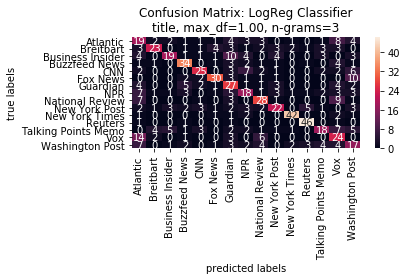

In [151]:
n = 3
params = {'solver' : ['newton-cg', 'sag'], 'C': [3, 4, 5, 6, 7, 8, 9]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

In [154]:
algorithm_comparison.head(25)

algorithm n_train n_test use_title max_df n-gram  cv_score train_acc  \
3   RandomForest    3000    750     title      1      1  0.341333         1   
4   RandomForest    3000    750     title      1      2  0.354333         1   
5   RandomForest    3000    750     title      1      3  0.354333         1   
6   RandomForest    3000    750     title      1      1  0.350667      0.68   
7   RandomForest    3000    750     title      1      2  0.365333  0.678667   
8   RandomForest    3000    750     title      1      3     0.365  0.671667   
9            SVM    3000    750     title      1      1     0.463  0.855333   
10           SVM    3000    750     title      1      2  0.486333     0.877   
11           SVM    3000    750     title      1      3     0.487  0.876667   
12           SVM    3000    750     title      1      1  0.466667  0.932667   
13           SVM    3000    750     title      1      2  0.488333  0.879333   
14           SVM    3000    750     title      1      3     0.487  0.876667   
15        LogReg    3000    750     title      1      1     0.488  0.981667   
16        LogReg    3000    750     title      1      2  0.513333  0.985333   
17        LogReg    3000    750     title      1      3  0.518667  0.988333   
18        LogReg    3000    750     title      1      1  0.489333     0.947   
19        LogReg    3000    750     title      1      2  0.517667  0.958667   
20        LogReg    3000    750     title      1      3     0.521  0.959333   
21        LogReg    3000    750     title      1      1      0.49  0.916667   
22        LogReg    3000    750     title      1      2      0.52      0.93   
23        LogReg    3000    750     title      1      3  0.522667  0.975667   

    test_acc  
3   0.330667  
4   0.333333  
5       0.34  
6   0.337333  
7   0.354667  
8       0.36  
9   0.462667  
10      0.48  
11      0.48  
12     0.456  
13  0.477333  
14      0.48  
15  0.486667  
16     0.516  
17  0.517333  
18  0.490667  
19  0.513333  
20     0.524  
21     0.488  
22  0.506667  
23  0.522667

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  1
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=2, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=2, solver=newton-cg, total=   1.4s
[CV] C=2, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ............................ C=2, solver=newton-cg, total=   1.7s
[CV] C=2, solver=newton-cg ...........................................
[CV] ............................ C=2, solver=newton-cg, total=   1.0s
[CV] C=2, solver=newton-cg ...........................................
[CV] ............................ C=2, solver=newton-cg, total=   1.0s
[CV] C=2, solver=newton-cg ...........................................
[CV] ............................ C=2, solver=newton-cg, total=   1.0s
[CV] C=2, solver=sag .................................................
[CV] .................................. C=2, solver=sag, total=   4.5s
[CV] C=2, solver=sag .................................................
[CV] .................................. C=2, solver=sag, total=   4.4s
[CV] C=2, solver=sag .................................................
[CV] .................................. C=2, solver=sag, total=   4.4s
[CV] C=2, solver=sag .................................................
[CV] .

[CV] .................................. C=7, solver=sag, total=   8.5s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.2min finished


Best parameters:  {'C': 3, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.48       0.51666667 0.49166667 0.49166667 0.47      ]
CV score averaged across folds (best estimator):  0.49000000000000005
Training accuracy (best estimator):  0.9166666666666666
Test accuracy (best estimator):  0.488


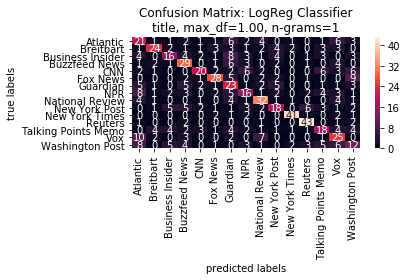

In [156]:
n = 1
params = {'solver' : ['newton-cg', 'sag'], 'C': [2, 3, 4, 5, 6, 7]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  2
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] C=2, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=2, solver=newton-cg, total=   1.6s
[CV] C=2, solver=newton-cg ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] ............................ C=2, solver=newton-cg, total=   1.6s
[CV] C=2, solver=newton-cg ...........................................
[CV] ............................ C=2, solver=newton-cg, total=   1.3s
[CV] C=2, solver=newton-cg ...........................................
[CV] ............................ C=2, solver=newton-cg, total=   1.4s
[CV] C=2, solver=newton-cg ...........................................
[CV] ............................ C=2, solver=newton-cg, total=   2.4s
[CV] C=2, solver=sag .................................................
[CV] .................................. C=2, solver=sag, total=   5.5s
[CV] C=2, solver=sag .................................................
[CV] .................................. C=2, solver=sag, total=   4.6s
[CV] C=2, solver=sag .................................................
[CV] .................................. C=2, solver=sag, total=   4.5s
[CV] C=2, solver=sag .................................................
[CV] .

[CV] .................................. C=7, solver=sag, total=   7.9s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.2min finished


Best parameters:  {'C': 3, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.51166667 0.55166667 0.51833333 0.51833333 0.5       ]
CV score averaged across folds (best estimator):  0.52
Training accuracy (best estimator):  0.93
Test accuracy (best estimator):  0.5066666666666667


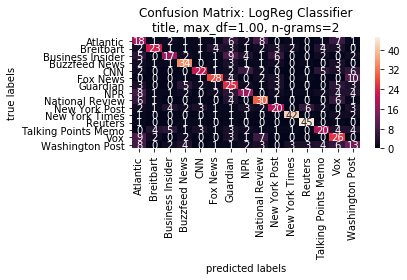

In [157]:
n = 2
params = {'solver' : ['newton-cg', 'sag'], 'C': [2, 3, 4, 5, 6, 7]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  1
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=2.0, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... C=2.0, solver=newton-cg, total=   1.5s
[CV] C=2.0, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV] .......................... C=2.0, solver=newton-cg, total=   1.4s
[CV] C=2.0, solver=newton-cg .........................................
[CV] .......................... C=2.0, solver=newton-cg, total=   1.0s
[CV] C=2.0, solver=newton-cg .........................................
[CV] .......................... C=2.0, solver=newton-cg, total=   1.0s
[CV] C=2.0, solver=newton-cg .........................................
[CV] .......................... C=2.0, solver=newton-cg, total=   1.1s
[CV] C=2.0, solver=sag ...............................................
[CV] ................................ C=2.0, solver=sag, total=   4.3s
[CV] C=2.0, solver=sag ...............................................
[CV] ................................ C=2.0, solver=sag, total=   6.3s
[CV] C=2.0, solver=sag ...............................................
[CV] ................................ C=2.0, solver=sag, total=   4.6s
[CV] C=2.0, solver=sag ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.8min finished


Best parameters:  {'C': 3.5, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.47666667 0.515      0.49333333 0.49166667 0.475     ]
CV score averaged across folds (best estimator):  0.49033333333333334
Training accuracy (best estimator):  0.929
Test accuracy (best estimator):  0.49066666666666664


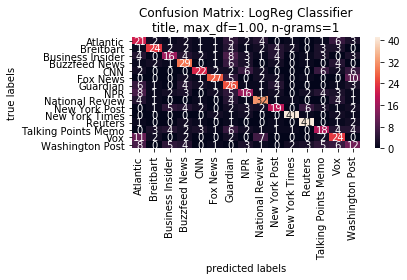

In [158]:
n = 1
params = {'solver' : ['newton-cg', 'sag'], 'C': [2.0, 2.5, 3., 3.5, 4.]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  2
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=2.0, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... C=2.0, solver=newton-cg, total=   1.6s
[CV] C=2.0, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV] .......................... C=2.0, solver=newton-cg, total=   2.1s
[CV] C=2.0, solver=newton-cg .........................................
[CV] .......................... C=2.0, solver=newton-cg, total=   2.4s
[CV] C=2.0, solver=newton-cg .........................................
[CV] .......................... C=2.0, solver=newton-cg, total=   1.3s
[CV] C=2.0, solver=newton-cg .........................................
[CV] .......................... C=2.0, solver=newton-cg, total=   2.2s
[CV] C=2.0, solver=sag ...............................................
[CV] ................................ C=2.0, solver=sag, total=   6.5s
[CV] C=2.0, solver=sag ...............................................
[CV] ................................ C=2.0, solver=sag, total=   6.2s
[CV] C=2.0, solver=sag ...............................................
[CV] ................................ C=2.0, solver=sag, total=   5.3s
[CV] C=2.0, solver=sag ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  3.2min finished


Best parameters:  {'C': 2.5, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.51666667 0.55       0.51333333 0.52       0.50166667]
CV score averaged across folds (best estimator):  0.5203333333333333
Training accuracy (best estimator):  0.9163333333333333
Test accuracy (best estimator):  0.5093333333333333


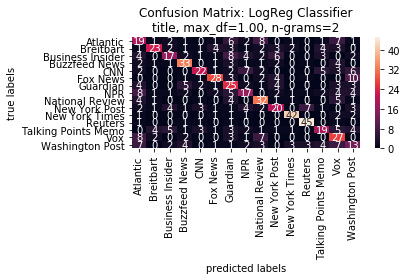

In [159]:
n = 2
params = {'solver' : ['newton-cg', 'sag'], 'C': [2.0, 2.5, 3., 3.5, 4.]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

----Logistic Regression-----
use_title:  title , max_df:  1.0 n-gram:  3
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] C=6.0, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................... C=6.0, solver=newton-cg, total=   2.0s
[CV] C=6.0, solver=newton-cg .........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


[CV] .......................... C=6.0, solver=newton-cg, total=   2.8s
[CV] C=6.0, solver=newton-cg .........................................
[CV] .......................... C=6.0, solver=newton-cg, total=   1.5s
[CV] C=6.0, solver=newton-cg .........................................
[CV] .......................... C=6.0, solver=newton-cg, total=   1.5s
[CV] C=6.0, solver=newton-cg .........................................
[CV] .......................... C=6.0, solver=newton-cg, total=   1.6s
[CV] C=6.0, solver=sag ...............................................
[CV] ................................ C=6.0, solver=sag, total=   7.8s
[CV] C=6.0, solver=sag ...............................................
[CV] ................................ C=6.0, solver=sag, total=   8.7s
[CV] C=6.0, solver=sag ...............................................
[CV] ................................ C=6.0, solver=sag, total=   7.8s
[CV] C=6.0, solver=sag ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.5min finished


Best parameters:  {'C': 6.5, 'solver': 'newton-cg'}
CV score for each fold (best estimator):  [0.525      0.53833333 0.53333333 0.51166667 0.51      ]
CV score averaged across folds (best estimator):  0.5236666666666666
Training accuracy (best estimator):  0.9726666666666667
Test accuracy (best estimator):  0.5226666666666666


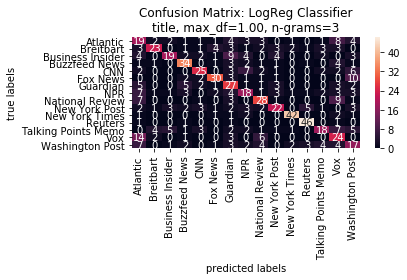

In [160]:
n = 3
params = {'solver' : ['newton-cg', 'sag'], 'C': [6.0, 6.5, 7., 7.5, 8.]}
classifier = LogisticRegression(penalty='l2', multi_class='multinomial')
print('----Logistic Regression-----')
algorithm_comparison.loc[i, 'algorithm'] = 'LogReg'
# chose one with highest variance explained by SVD
algorithm_score(classifier, params, True, (n, 2), i, 'LogReg')
i += 1

In [412]:
# read test_data_final.csv file into DataFrame and preprocess title
toast = pd.read_csv('test_dataset_final.csv', sep=',', header=None, index_col=False)
data_test_final = toast
data_test_final = data_test_final.drop(labels=0, axis='columns')
#data_test_final = data_test_final.drop(labels=0, axis='columns')
data_test_final.columns = ['id', 'title', 'publication', 'author', 'date', 'year', 'month', 'url', 'content']

#idx_list = []
#for j in range(15):
    #idx_list += [2000*j + k for k in range(210)]
    #idx_list += [2000*j + k for k in range(260, 2000)]
#print(idx_list)
#data_test_final = data_test_final.drop(idx_list)
#data_test_final = data_test_final.reset_index()

#print('Dataframes equal?', pd.DataFrame.equals(data_test, data_test_final))
print(data_test_final)
print(data_test)

for j in range(len(data_test_final)):
    #Lemmatization
    doc = nlp(data_test_final.loc[j, 'title'])
    new_title = " ".join([token.lemma_ for token in doc])
    new_title = new_title.replace('-PRON- ', '')
    new_title = re.sub(r'[^a-zA-Z]', " ", new_title.lower())
    data_test_final.loc[j, 'title'] = new_title

# concatenate title
content_data_test_final = data_test_final[['title', 'content', 'publication']]
content_title_data_test_final = pd.DataFrame(columns=['content', 'publication'])
for j in range(len(content_data_test_final)):
    content_title_data_test_final.loc[j, 'publication'] = content_data_test_final.loc[j, 'publication']
    # article titles often have '- Publication' at the end of the title - remove this bc too big a hint
    corrected_title = re.sub((content_data_test_final.loc[j, 'publication']).lower(), '', content_data_test_final.loc[j, 'title'])
    content_title_data_test_final.loc[j, 'content'] = corrected_title + ' ' + content_data_test_final.loc[j, 'content']

# get final test sets
X_test_final = {'content' : content_data_test_final.loc[:, 'content'], 'title' : content_title_data_test_final.loc[:, 'content']}
y_test_final = {'content': [label_dict[pub] for pub in content_data_test_final.loc[:, 'publication']], 'title': [label_dict[pub] for pub in content_title_data_test_final.loc[:, 'publication']]}

# get term-document matrices (entries are tf-idf for each word) for final test set
X_test_tfidf_final = {}
for max_n in max_ngram:
    X_test_tfidf_final[max_n] = {}
    for k, v in X_test_final.items():
        X_test_tfidf_final[max_n][k] = []
        for i in range(len(max_dfs)):
            X_test_tfidf_final[max_n][k].append(vectorizers[max_n][k][i].transform(X_test_final[k]))
            #print('n_grams ', max_n, ' test ', k, ' max_df ', max_dfs[i], ' done')

# dictionary of tf-idf final test data after TruncatedSVD transfrom (transform was learned from training data)
X_test_lsa_final = {}
X_test_lsa_final[1] = {}
X_test_lsa_final[1]['content'] = []
(X_test_lsa_final[1]['content']).append(lsa[1]['content'][0].transform(X_test_tfidf_final[1]['content'][0]))

# dictionary of tf-idf final test data after TruncatedSVD transfrom (transform was learned from training data)
X_test_lsa_final[2] = {}
X_test_lsa_final[2]['content'] = []
(X_test_lsa_final[2]['content']).append(lsa[2]['content'][0].transform(X_test_tfidf_final[2]['content'][0]))

# dictionary of tf-idf final test data after TruncatedSVD transfrom (transform was learned from training data)
X_test_lsa_final[3] = {}
X_test_lsa_final[3]['content'] = []
(X_test_lsa_final[3]['content']).append(lsa[3]['content'][0].transform(X_test_tfidf_final[3]['content'][0]))

# dictionary of tf-idf final test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[1]['content']).append(lsa[1]['content'][1].transform(X_test_tfidf_final[1]['content'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[2]['content']).append(lsa[2]['content'][1].transform(X_test_tfidf_final[2]['content'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[3]['content']).append(lsa[3]['content'][1].transform(X_test_tfidf_final[3]['content'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[1]['content']).append(lsa[1]['content'][2].transform(X_test_tfidf_final[1]['content'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[2]['content']).append(lsa[2]['content'][2].transform(X_test_tfidf_final[2]['content'][2]))

(X_test_lsa_final[3]['content']).append(lsa[3]['content'][2].transform(X_test_tfidf_final[3]['content'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
#X_test_lsa = {}
X_test_lsa_final[1]['title'] = []
(X_test_lsa_final[1]['title']).append(lsa[1]['title'][0].transform(X_test_tfidf_final[1]['title'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
#X_test_lsa = {}
X_test_lsa_final[2]['title'] = []
(X_test_lsa_final[2]['title']).append(lsa[2]['title'][0].transform(X_test_tfidf_final[2]['title'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
#X_test_lsa = {}
X_test_lsa_final[3]['title'] = []
(X_test_lsa_final[3]['title']).append(lsa[3]['title'][0].transform(X_test_tfidf_final[3]['title'][0]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[1]['title']).append(lsa[1]['title'][1].transform(X_test_tfidf_final[1]['title'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[2]['title']).append(lsa[2]['title'][1].transform(X_test_tfidf_final[2]['title'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[3]['title']).append(lsa[3]['title'][1].transform(X_test_tfidf_final[3]['title'][1]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[1]['title']).append(lsa[1]['title'][2].transform(X_test_tfidf_final[1]['title'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[2]['title']).append(lsa[2]['title'][2].transform(X_test_tfidf_final[2]['title'][2]))

# dictionary of tf-idf test data after TruncatedSVD transfrom (transform was learned from training data)
(X_test_lsa_final[3]['title']).append(lsa[3]['title'][2].transform(X_test_tfidf_final[3]['title'][2]))


          id                                              title  \
0      19529  Now on Twitter: Chelsea Clinton, Unbound - The...   
1      19530  For Kansas Coach Bill Self, Sticking to Basket...   
2      19531  UConn’s Recipe for Success Is to Run, Run and ...   
3      19532  At Asia’s Hottest Art Fair, Taking Selfies Wit...   
4      19533   The Man Who Loathed Pajamas - The New York Times   
5      19534  John Mayer Knows He Messed Up. He Wants Anothe...   
6      19535  In Major Defeat for Trump, Push to Repeal Heal...   
7      19536  Trump’s Choice on Obamacare: Sabotage or Co-op...   
8      19537  In Dropping Health Vote, Trump Swallowed Need ...   
9      19539  In a Call to The Times, Trump Blames Democrats...   
10     19540  Fact Check: Trump’s Misleading Claims on the H...   
11     19541  Republicans Land a Punch on Health Care, to Th...   
12     19542  Civics Lesson Unfolds at Capitol as Health Car...   
13     19543  London, Donald Trump, Keystone Pipeline: Your ..

In [ ]:
vectorizer_2_title_2 = joblib.load('vectorizer_2_title_2.joblib')
vectorizer_3_title_2 = joblib.load('vectorizer_3_title_2.joblib')
lsa_2_title_2 = joblib.load('lsa_2_title_2.joblib')
lsa_3_title_2 = joblib.load('lsa_3_title_2.joblib')

X_test_tfidf_2_title_2 = vectorizer_2_title_2.transform(X_test_final['title'])
X_test_tfidf_3_title_2 = vectorizer_3_title_2.transform(X_test_final['title'])
X_test_lsa_2_title_2 = lsa_2_title_2.transform(X_test_tfidf_2_title_2)
X_test_lsa_3_title_2 = lsa_3_title_2.transform(X_test_tfidf_3_title_2)



In [413]:
print(X_test_tfidf_final[1]['title'][2])
# sanity check lengths
print(len(X_test_final))
print(len(X_test_final['content']))
print(len(X_test_final['title']))

print(len(X_test_tfidf_final))
for n in max_ngram:
    print(len(X_test_tfidf_final[n]['content']))
    print(X_test_tfidf_final[n]['content'][0].shape)
    print(X_test_tfidf_final[n]['content'][1].shape)
    print(X_test_tfidf_final[n]['content'][2].shape)
    print(len(X_test_tfidf_final[n]['title']))
    print(X_test_tfidf_final[n]['title'][0].shape)
    print(X_test_tfidf_final[n]['title'][1].shape)
    print(X_test_tfidf_final[n]['title'][2].shape)

print(len(X_test_lsa_final))
for n in max_ngram:
    print(len(X_test_lsa_final[n]['content']))
    print(X_test_lsa_final[n]['content'][0].shape)
    print(X_test_lsa_final[n]['content'][1].shape)
    print(X_test_lsa_final[n]['content'][2].shape)
    print(len(X_test_lsa_final[n]['title']))
    print(X_test_lsa_final[n]['title'][0].shape)
    print(X_test_lsa_final[n]['title'][1].shape)
    print(X_test_lsa_final[n]['title'][2].shape)

print(len(y_test_final))
print(len(y_test_final['content']))
print(len(y_test_final['title']))

print('Dataframes equal?', pd.DataFrame.equals(data_test, data_test_final))
data_test_final.head()

  (0, 8417)	0.014310901536190714
  (0, 8414)	0.024615008899331898
  (0, 8409)	0.017351460840882085
  (0, 8402)	0.020827031642549614
  (0, 8389)	0.022086802392653367
  (0, 8366)	0.010797098409490788
  (0, 8358)	0.009010964682803328
  (0, 8350)	0.03754193610018464
  (0, 8347)	0.01281649811675808
  (0, 8319)	0.01799791142443268
  (0, 8273)	0.00976285737948141
  (0, 8254)	0.026863441182966057
  (0, 8241)	0.011450290890793045
  (0, 8222)	0.01864753003900709
  (0, 8193)	0.016474607145948734
  (0, 8182)	0.050397741120962354
  (0, 8171)	0.01674362021701133
  (0, 8054)	0.017969048129851017
  (0, 8032)	0.01831800508554037
  (0, 7924)	0.02807697562628057
  (0, 7868)	0.07964847554365069
  (0, 7862)	0.20728112211726074
  (0, 7836)	0.018883940401943623
  (0, 7829)	0.025309013269005434
  (0, 7754)	0.020995273337452998
  :	:
  (1499, 504)	0.021422226458404164
  (1499, 450)	0.025335096177147874
  (1499, 419)	0.02418465563127867
  (1499, 394)	0.023837667085724053
  (1499, 327)	0.03225160792339913
  (149

id                                              title     publication  \
0  19529  now on twitter   chelsea clinton   unbound   t...  New York Times   
1  19530  for kansas coach bill self   stick to basketba...  New York Times   
2  19531  uconn  s recipe for success be to run   run an...  New York Times   
3  19532  at asia  s hottest art fair   take selfies wit...  New York Times   
4  19533    the man who loathe pajamas   the new york times  New York Times   

           author        date    year  month  url  \
0    Katie Rogers  2017-03-23  2017.0    3.0  NaN   
1    Juliet Macur  2017-03-27  2017.0    3.0  NaN   
2    Jeré Longman  2017-03-25  2017.0    3.0  NaN   
3         Amy Qin  2017-03-25  2017.0    3.0  NaN   
4  Jon Caramanica  2017-04-04  2017.0    4.0  NaN   

                                             content  
0  in the month lead to the      presidential ele...  
1  kansas city   mo         kansas coach bill sel...  
2  storrs   connecticut        after lose to conn...  
3  hong kong         s not every day that get to ...  
4  two day before the snowstorm that be suppose t...

In [395]:
data_test.head()

id                                              title     publication  \
0  17522  republicans   facing pressure   delay hearings...  New York Times   
1  17523  trump ask critic of vaccine to lead vaccine sa...  New York Times   
2  17524  session   trump   dylann roof   tuesday evenin...  New York Times   
3  17525  morning briefing   rafsanjani   donald trump  ...  New York Times   
4  17526  california today       million in tech money f...  New York Times   

                                              author        date    year  \
0                 Jennifer Steinhauer and Steve Eder  2017-01-11  2017.0   
1  Michael D. Shear, Nicholas Fandos and Jennifer...  2017-01-11  2017.0   
2                       Karen Zraick and Lisa Iaboni  2017-01-10  2017.0   
3                                   Charles McDermid  2017-01-10  2017.0   
4                                       Mike McPhate  2017-01-10  2017.0   

   month  url                                            content  
0    1.0  NaN  washington        senate republicans   under i...  
1    1.0  NaN    robert f  kennedy jr  one of the nation  s m...  
2    1.0  NaN    want to get this briefing by email   here   ...  
3    1.0  NaN  good morning     here   what need to know     ...  
4    1.0  NaN  good morning       want to get california toda...

In [215]:
algorithm_comparison.head(40)

algorithm n_train n_test use_title max_df n-gram  cv_score train_acc  \
3   RandomForest    3000    750     title      1      1  0.341333         1   
4   RandomForest    3000    750     title      1      2  0.354333         1   
5   RandomForest    3000    750     title      1      3  0.354333         1   
6   RandomForest    3000    750     title      1      1  0.350667      0.68   
7   RandomForest    3000    750     title      1      2  0.365333  0.678667   
8   RandomForest    3000    750     title      1      3     0.365  0.671667   
9            SVM    3000    750     title      1      1     0.463  0.855333   
10           SVM    3000    750     title      1      2  0.486333     0.877   
11           SVM    3000    750     title      1      3     0.487  0.876667   
12           SVM    3000    750     title      1      1  0.466667  0.932667   
13           SVM    3000    750     title      1      2  0.488333  0.879333   
14           SVM    3000    750     title      1      3     0.487  0.876667   
15        LogReg    3000    750     title      1      1     0.488  0.981667   
16        LogReg    3000    750     title      1      2  0.513333  0.985333   
17        LogReg    3000    750     title      1      3  0.518667  0.988333   
18        LogReg    3000    750     title      1      1  0.489333     0.947   
19        LogReg    3000    750     title      1      2  0.517667  0.958667   
20        LogReg    3000    750     title      1      3     0.521  0.959333   
21        LogReg    3000    750     title      1      1      0.49  0.916667   
22        LogReg    3000    750     title      1      2      0.52      0.93   
23        LogReg    3000    750     title      1      3  0.522667  0.975667   
24        LogReg    3000    750     title      1      1      0.49  0.916667   
25        LogReg    3000    750     title      1      2      0.52      0.93   
26        LogReg    3000    750     title      1      1  0.490333     0.929   
27        LogReg    3000    750     title      1      2  0.520333  0.916333   
28        LogReg    3000    750     title      1      3  0.523667  0.972667   

    test_acc  
3   0.330667  
4   0.333333  
5       0.34  
6   0.337333  
7   0.354667  
8       0.36  
9   0.462667  
10      0.48  
11      0.48  
12     0.456  
13  0.477333  
14      0.48  
15  0.486667  
16     0.516  
17  0.517333  
18  0.490667  
19  0.513333  
20     0.524  
21     0.488  
22  0.506667  
23  0.522667  
24     0.488  
25  0.506667  
26  0.490667  
27  0.509333  
28  0.522667

In [216]:
print(best_models[7]) # best overall RandomForest (CV score)
print(best_models[13]) # best overall SVM (CV score)
print(best_models[28]) # best overall LogisticRegression (CV score)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
LogisticRegression(C=6.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', 

now on twitter   chelsea clinton   unbound   the  in the month lead to the      presidential election   democratic voter have a consistent place to look for update on hillary clinton  s campaign   daughter  s twitter feed   from report on campus visit to facetime session with supporter   chelsea clinton  s tweet be positive   inclusive and unfailingly on message     could not be more proud of mom and the campaign  s run     ms  clinton write on election day     let bring home for today     thing do not work out as plan   of course   and after donald j  trump   and not mother   be swear in as the country  s   th president   another side of chelsea clinton seem to emerge   in recent week   have greet the trump era with a more sarcastic and feisty online personality   share with       million follower fiercely hold political belief and spar with political adversary in    burst   ms  clinton have accuse a trump adviser of spread misinformation   admonish a republican congressman for racist

---  SVM , n-gram= 2 , title= title , max_df= 1.0  ---
Test accuracy (best estimator):  0.4093333333333333
---  LogReg , n-gram= 3 , title= title , max_df= 1.0  ---
Test accuracy (best estimator):  0.43133333333333335


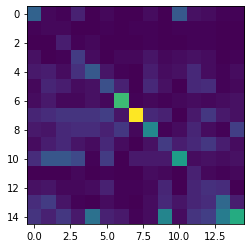

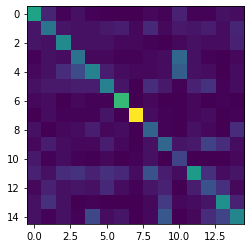

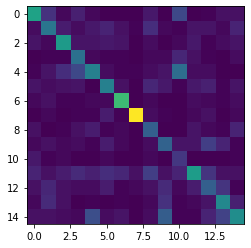

In [414]:
conf_mats_final = {}
print(X_test_final['title'][0])
print(label_dict_inv[y_test_final['title'][0]])
print(X_test['title'][0])
print(label_dict_inv[y_test['title'][0]])
for tbl_idx in [7, 13, 28]:
    print('--- ', algorithm_comparison.loc[tbl_idx, 'algorithm'], ', n-gram=', algorithm_comparison.loc[tbl_idx, 'n-gram'], ', title=', algorithm_comparison.loc[tbl_idx, 'use_title'], ', max_df=', algorithm_comparison.loc[tbl_idx, 'max_df'], ' ---')
    algo_name = algorithm_comparison.loc[tbl_idx, 'algorithm']
    n = algorithm_comparison.loc[tbl_idx, 'n-gram']
    key = algorithm_comparison.loc[tbl_idx, 'use_title']
    df = 2
    
    # use best parameters on whole training set for test accuracy
    test_acc = best_models[tbl_idx].score(X=np.array(X_test_lsa_final[n][key][df]), y=np.array(y_test_final[key]))
    print('Test accuracy (best estimator): ', test_acc)
    
    # create confusion matrix
    y_pred = best_models[tbl_idx].predict(np.array(X_test_lsa_final[n][key][df]))
    #conf_mat = pd.crosstab(np.array(y_test[key]), y_pred)
    
    true_names = [label_dict_inv[j] for j in y_test_final[key]]
    pred_names = [label_dict_inv[j] for j in y_pred]
    result_dataframe = pd.DataFrame(columns=['true labels', 'predicted labels'])
    result_dataframe.loc[:,'true labels'] = true_names
    result_dataframe.loc[:,'predicted labels'] = pred_names

    conf_mat = np.zeros((15, 15))
    plt.figure()
    for p, t in zip(y_pred, y_test_final[key]):
        conf_mat[p, t] += 1
    plt.imshow(conf_mat)
    #conf_mat = pd.crosstab(result_dataframe['true labels'], result_dataframe['predicted labels'])
    #best_conf_mat[i] = conf_mat
    #sns.heatmap(conf_mat, annot=True)
    #plt.title('Confusion Matrix: %s Classifier\n%s, max_df=%.2f, n-grams=%d' % (algo_name, key, max_dfs[df], n))
    #plt.tight_layout()
    #plt.savefig('final_confmat_%s_%s_%.2f_%d_i%d.png' % (algo_name, key, max_dfs[df], n, tbl_idx))

In [ ]:
#best_model_7, 13, 28
# use best parameters on whole training set for test accuracy
test_acc = best_model_7.score(X=np.array(X_test_lsa_2_title_2), y=np.array(y_test_final[key]))
print('Test accuracy (best estimator): ', test_acc)

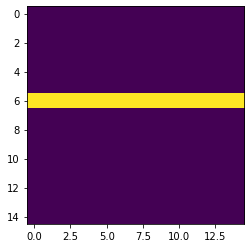

In [232]:
plt.imshow(conf_mat)

In [198]:
for n in [1, 2, 3]:
    for pc in [0, 1, 8, 9]:
        print('Principle Component ', pc, ':\n')
        neg_idxes = np.argsort(lsa[n]['title'][2].steps[0][1].components_[pc,:])
        pos_idxes = np.argsort(-np.array(lsa[n]['title'][2].steps[0][1].components_[pc,:]))
        
        print('10 most positive words:')
        for j in range(10):
            #print(n, pos_idxes[j])
            print(vectorizers[n]['title'][2].get_feature_names()[pos_idxes[j]], '\t', 
                 lsa[n]['title'][2].steps[0][1].components_[pc, pos_idxes[j]])
            
        print('\n10 most negative words:')
        for j in range(10):
            print(vectorizers[n]['title'][2].get_feature_names()[neg_idxes[j]], '\t',
                 lsa[n]['title'][2].steps[0][1].components_[pc, neg_idxes[j]])
        print('\n\n')
# TODO: put in nice format for the report        
        

Principle Component  0 :

10 most positive words:
trump 	 0.309652745534754
say 	 0.2487643730987687
obama 	 0.11737427374684273
president 	 0.11072658601107394
people 	 0.10657379943492518
russia 	 0.10249345299626175
year 	 0.09578591064239171
new 	 0.09538502745185062
make 	 0.09252223083119908
intelligence 	 0.09095336924692458

10 most negative words
flick 	 0.0004016874357713338
heir 	 0.00041381705274022346
cadre 	 0.0004162397560660721
lush 	 0.00044818332528026166
catapult 	 0.0004491139350331435
misogynistic 	 0.0004496148099024016
invasive 	 0.00045338041757185836
telltale 	 0.00045694538929469457
mentality 	 0.0004685387571154254
miniature 	 0.0004712081962502401



Principle Component  1 :

10 most positive words:
repeal 	 0.3576860233055914
obamacare 	 0.33149843896527614
republicans 	 0.25967035394869686
trump 	 0.17809066417511374
replacement 	 0.15789514427425255
senate 	 0.14941761374528031
insurance 	 0.14651915580894606
democrats 	 0.1327335836903548
health 	 0.1323

(3000,)
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
LogisticRegression(C=6.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newt

Text(0, 0.5, 'X8')

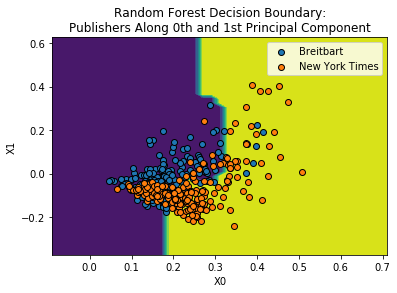

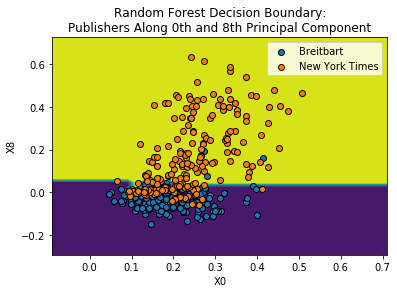

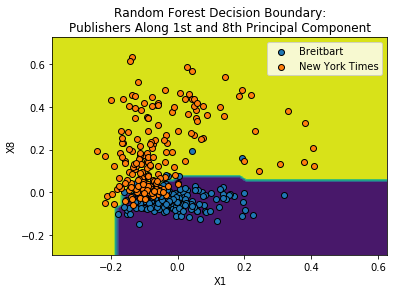

In [417]:
#2-GRAMS

# make scatter plots of (x0, x1), (x0, x8), (x1, x8)
# best classifier for these (retrain it on just the 2 points)
# plot decision boundary
# best models have n-grams: random forest: 2, SVM: 2, logisitic regression: 3
X_train_lsa_np = {}
X_train_lsa_np[2] = np.array(X_train_lsa[2]['title'][2])
X_train_lsa_np[3] = np.array(X_train_lsa[3]['title'][2])
y_train_np = np.array(y_train['title'])

legend_labels = [label_dict_inv[j] for j in range(15)]
    
print(X_train_lsa_np[2][:, 0].shape)
X0, X1, X8 = X_train_lsa_np[2][:, 0], X_train_lsa_np[2][:, 1], X_train_lsa_np[2][:, 8]
fig, ax = plt.subplots()
model_num = [7, 13, 28]
for m in model_num:
    print(best_models[m])
#print(X0.shape)
#print(X1.shape)
#print(X8.shape)
#print(y_train_np)
#print(X0[y_train_np==j].shape)
#print(X1[y_train_np==j].shape)
#print(X8[y_train_np==j].shape)
def get_meshgrid(x, y, delta=.02):
    x_min, x_max, = x.min()-.1, x.max()+.1
    y_min, y_max = y.min()-.1, y.max()+.1
    print('x', x_min, x_max)
    print('y', y_min, y_max)
    xx, yy = np.meshgrid(np.arange(x_min, x_max, delta), np.arange(y_min, y_max, delta))
    return xx, yy
def plot_contours(ax, clf, xx, yy):
    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    out = ax.contourf(xx, yy, z)
    return out

color = ['tab:blue', 'tab:orange']
cls_idx = [0, 6]

X_joined = np.concatenate((X0[:, np.newaxis], X1[:, np.newaxis]), axis=1)
X_joined = X_joined[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1]), :]
y_joined = y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
clf = model.fit(X_joined, y_joined)
xx, yy = get_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy)

for j in range(2):
    ax.scatter(X0[y_train_np==cls_idx[j]], X1[y_train_np==cls_idx[j]], edgecolors='k', label=legend_labels[cls_idx[j]])
    ax.legend()
plt.title('Random Forest Decision Boundary:\nPublishers Along 0th and 1st Principal Component')
plt.xlabel('X0')
plt.ylabel('X1')


fig, ax = plt.subplots()

X_joined = np.concatenate((X0[:, np.newaxis], X8[:, np.newaxis]), axis=1)
X_joined = X_joined[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1]), :]
y_joined = y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
clf = model.fit(X_joined, y_joined)
xx, yy = get_meshgrid(X0, X8)
plot_contours(ax, clf, xx, yy)

for j in range(2):
    ax.scatter(X0[y_train_np==cls_idx[j]], X8[y_train_np==cls_idx[j]], c=color[j], edgecolors='k', label=legend_labels[cls_idx[j]])
    ax.legend()
plt.title('Random Forest Decision Boundary:\nPublishers Along 0th and 8th Principal Component')
plt.xlabel('X0')
plt.ylabel('X8')

fig, ax = plt.subplots()

X_joined = np.concatenate((X1[:, np.newaxis], X8[:, np.newaxis]), axis=1)
X_joined = X_joined[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1]), :]
y_joined = y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
clf = model.fit(X_joined, y_joined)
xx, yy = get_meshgrid(X1, X8)
plot_contours(ax, clf, xx, yy)

for j in range(2):
    ax.scatter(X1[y_train_np==cls_idx[j]], X8[y_train_np==cls_idx[j]], c=color[j], edgecolors='k', label=legend_labels[cls_idx[j]])
ax.legend()
plt.title('Random Forest Decision Boundary:\nPublishers Along 1st and 8th Principal Component')
plt.xlabel('X1')
plt.ylabel('X8')

# plot decision boundary after t-SNE

# make confusion matrices of shit data (X_test_final)

x -0.08891531002013202 0.7144066008030425
y -0.3736093010567978 0.6434555310565548
x -0.08891531002013202 0.7144066008030425
y -0.29324128794197624 0.7335006376739258
x -0.3736093010567978 0.6434555310565548
y -0.29324128794197624 0.7335006376739258


Text(0, 0.5, 'X8')

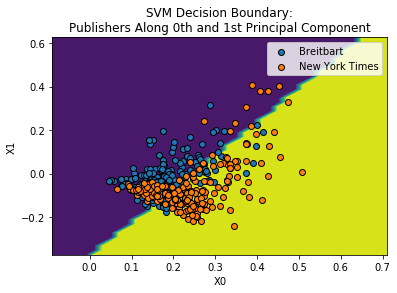

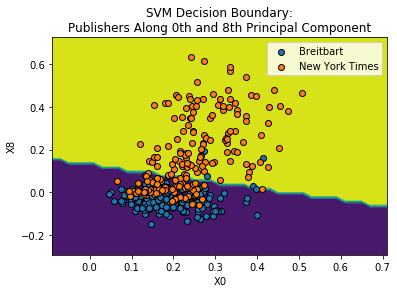

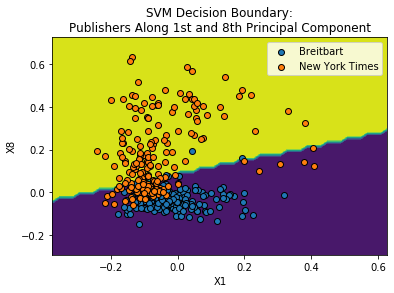

In [418]:
# SVM decision boundaries on principle components (0, 1), (0, 8), (1, 8)

#0, 1
fig, ax = plt.subplots()
X_joined = np.concatenate((X0[:, np.newaxis], X1[:, np.newaxis]), axis=1)
X_joined = X_joined[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1]), :]
y_joined = y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
model = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
clf = model.fit(X_joined, y_joined)
xx, yy = get_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy)

for j in range(2):
    ax.scatter(X0[y_train_np==cls_idx[j]], X1[y_train_np==cls_idx[j]], edgecolors='k', label=legend_labels[cls_idx[j]])
    ax.legend()
plt.title('SVM Decision Boundary:\nPublishers Along 0th and 1st Principal Component')
plt.xlabel('X0')
plt.ylabel('X1')

#0, 8
fig, ax = plt.subplots()
X_joined = np.concatenate((X0[:, np.newaxis], X8[:, np.newaxis]), axis=1)
X_joined = X_joined[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1]), :]
y_joined = y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
model = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
clf = model.fit(X_joined, y_joined)
xx, yy = get_meshgrid(X0, X8)
plot_contours(ax, clf, xx, yy)

for j in range(2):
    ax.scatter(X0[y_train_np==cls_idx[j]], X8[y_train_np==cls_idx[j]], c=color[j], edgecolors='k', label=legend_labels[cls_idx[j]])
    ax.legend()
plt.title('SVM Decision Boundary:\nPublishers Along 0th and 8th Principal Component')
plt.xlabel('X0')
plt.ylabel('X8')


#1, 8
fig, ax = plt.subplots()
X_joined = np.concatenate((X1[:, np.newaxis], X8[:, np.newaxis]), axis=1)
X_joined = X_joined[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1]), :]
y_joined = y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
model = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
clf = model.fit(X_joined, y_joined)
xx, yy = get_meshgrid(X1, X8)
plot_contours(ax, clf, xx, yy)

for j in range(2):
    ax.scatter(X1[y_train_np==cls_idx[j]], X8[y_train_np==cls_idx[j]], c=color[j], edgecolors='k', label=legend_labels[cls_idx[j]])
ax.legend()
plt.title('SVM Decision Boundary:\nPublishers Along 1st and 8th Principal Component')
plt.xlabel('X1')
plt.ylabel('X8')

x -0.08884745957294504 0.7136853556619154
y -0.3697312520675732 0.6621148391969442
x -0.08884745957294504 0.7136853556619154
y -0.3014125886596787 0.7135418106147142
x -0.3697312520675732 0.6621148391969442
y -0.3014125886596787 0.7135418106147142


Text(0, 0.5, 'X8')

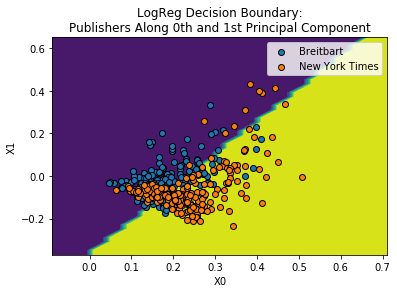

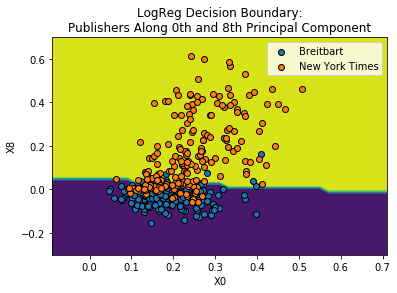

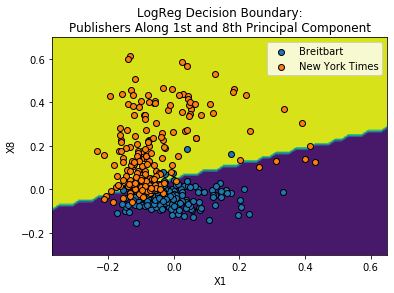

In [419]:
# 3-GRAMS

# LogReg decision boundaries on principle components (0, 1), (0, 8), (1, 8)
X0, X1, X8 = X_train_lsa_np[3][:, 0], X_train_lsa_np[3][:, 1], X_train_lsa_np[3][:, 8]

#0, 1
fig, ax = plt.subplots()
X_joined = np.concatenate((X0[:, np.newaxis], X1[:, np.newaxis]), axis=1)
X_joined = X_joined[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1]), :]
y_joined = y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
model = LogisticRegression(C=6.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
clf = model.fit(X_joined, y_joined)
xx, yy = get_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy)

for j in range(2):
    ax.scatter(X0[y_train_np==cls_idx[j]], X1[y_train_np==cls_idx[j]], edgecolors='k', label=legend_labels[cls_idx[j]])
    ax.legend()
plt.title('LogReg Decision Boundary:\nPublishers Along 0th and 1st Principal Component')
plt.xlabel('X0')
plt.ylabel('X1')

#0, 8
fig, ax = plt.subplots()
X_joined = np.concatenate((X0[:, np.newaxis], X8[:, np.newaxis]), axis=1)
X_joined = X_joined[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1]), :]
y_joined = y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
model = LogisticRegression(C=6.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
clf = model.fit(X_joined, y_joined)
xx, yy = get_meshgrid(X0, X8)
plot_contours(ax, clf, xx, yy)

for j in range(2):
    ax.scatter(X0[y_train_np==cls_idx[j]], X8[y_train_np==cls_idx[j]], c=color[j], edgecolors='k', label=legend_labels[cls_idx[j]])
    ax.legend()
plt.title('LogReg Decision Boundary:\nPublishers Along 0th and 8th Principal Component')
plt.xlabel('X0')
plt.ylabel('X8')


#1, 8
fig, ax = plt.subplots()
X_joined = np.concatenate((X1[:, np.newaxis], X8[:, np.newaxis]), axis=1)
X_joined = X_joined[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1]), :]
y_joined = y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
model = LogisticRegression(C=6.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
clf = model.fit(X_joined, y_joined)
xx, yy = get_meshgrid(X1, X8)
plot_contours(ax, clf, xx, yy)

for j in range(2):
    ax.scatter(X1[y_train_np==cls_idx[j]], X8[y_train_np==cls_idx[j]], c=color[j], edgecolors='k', label=legend_labels[cls_idx[j]])
ax.legend()
plt.title('LogReg Decision Boundary:\nPublishers Along 1st and 8th Principal Component')
plt.xlabel('X1')
plt.ylabel('X8')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.020s...
[t-SNE] Computed neighbors for 3000 samples in 0.907s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.129050
[t-SNE] Computed conditional probabilities in 0.185s
[t-SNE] Iteration 50: error = 78.2936707, gradient norm = 0.0244732 (50 iterations in 2.585s)
[t-SNE] Iteration 100: error = 76.5415497, gradient norm = 0.0170753 (50 iterations in 1.689s)
[t-SNE] Iteration 150: error = 76.4333344, gradient norm = 0.0083619 (50 iterations in 1.417s)
[t-SNE] Iteration 200: error = 76.4237976, gradient norm = 0.0115176 (50 iterations in 1.371s)
[t-SNE] Iteration 250: error = 76.4193726, gradient norm = 0.0088695 (50 iterations in 1.392s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.419373
[t-SNE] Iteration 300: err

Text(0.5, 1.0, 'Approximate Random Forest Decision Boundary,\nFeatures Transformed with t-SNE')

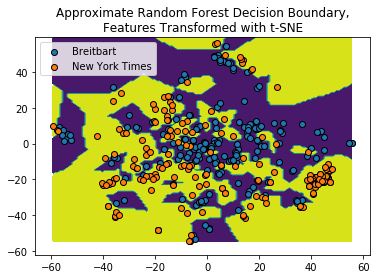

In [435]:
from sklearn.manifold import TSNE
from sklearn.neighbors.classification import KNeighborsClassifier

# 2-GRAM
#X_train_reduced_2 = TruncatedSVD(n_components=50).fit_transform(X_train_lsa_np[2])
X_train_embedded_2 = TSNE(n_components=2, perplexity=40., verbose=2).fit_transform((X_train_lsa_np[2])[:, :50])

x_tsne = X_train_embedded_2[:,0]
y_tsne = X_train_embedded_2[:,1]
#x_tsne = x_tsne[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
#y_tsne = y_tsne[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]

# random forest best model
model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
clf = model.fit((X_train_lsa_np[2])[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])],
                y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])])               
y_train_embedded_2_pred = clf.predict(X_train_lsa_np[2])

# color points in grid as nearest neighbor of what their true point was classified as
fig, ax = plt.subplots()
one_nn = KNeighborsClassifier(n_neighbors=1).fit(X_train_embedded_2[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])],
                                                 y_train_embedded_2_pred[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])])
xx, yy = get_meshgrid(x_tsne, y_tsne, delta=1)
plot_contours(ax, one_nn, xx, yy)

# scatter plot of Breitbart and New York Times posts
for j in range(2):
    ax.scatter(x_tsne[y_train_np==cls_idx[j]], y_tsne[y_train_np==cls_idx[j]], edgecolors='k', label=legend_labels[cls_idx[j]])
    ax.legend()
plt.title('Approximate Random Forest Decision Boundary,\nFeatures Transformed with t-SNE')
#ax.scatter(X_train_embedded_2[:,0], X_train_embedded_2[:,1], c=y_train['title'], cmap=plt.cm.coolwarm, s=20, edgecolors='k')

x -59.37606582641602 56.08429107666016
y -54.74956283569336 59.61807403564453


Text(0.5, 1.0, 'Approximate SVM Decision Boundary,\nFeatures Transformed with t-SNE')

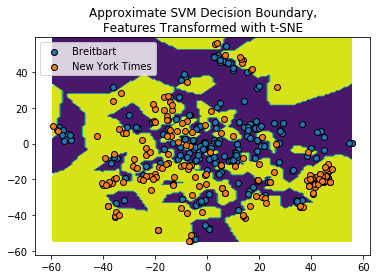

In [437]:
# SVM best model
model = SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
clf = model.fit((X_train_lsa_np[2])[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])],
                y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])])               
y_train_embedded_2_pred = clf.predict(X_train_lsa_np[2])

# color points in grid as nearest neighbor of what their true point was classified as
fig, ax = plt.subplots()
one_nn = KNeighborsClassifier(n_neighbors=1).fit(X_train_embedded_2[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])],
                                                 y_train_embedded_2_pred[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])])
xx, yy = get_meshgrid(x_tsne, y_tsne, delta=1)
plot_contours(ax, one_nn, xx, yy)

# scatter plot of Breitbart and New York Times posts
for j in range(2):
    ax.scatter(x_tsne[y_train_np==cls_idx[j]], y_tsne[y_train_np==cls_idx[j]], edgecolors='k', label=legend_labels[cls_idx[j]])
    ax.legend()
plt.title('Approximate SVM Decision Boundary,\nFeatures Transformed with t-SNE')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.004s...
[t-SNE] Computed neighbors for 3000 samples in 1.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.127142
[t-SNE] Computed conditional probabilities in 0.184s
[t-SNE] Iteration 50: error = 78.4228058, gradient norm = 0.0156382 (50 iterations in 3.177s)
[t-SNE] Iteration 100: error = 76.5056229, gradient norm = 0.0061271 (50 iterations in 1.588s)
[t-SNE] Iteration 150: error = 76.4247284, gradient norm = 0.0057339 (50 iterations in 1.385s)
[t-SNE] Iteration 200: error = 76.4206314, gradient norm = 0.0070727 (50 iterations in 1.373s)
[t-SNE] Iteration 250: error = 76.4225235, gradient norm = 0.0167702 (50 iterations in 1.369s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.422523
[t-SNE] Iteration 300: err

Text(0.5, 1.0, 'Approximate Logistic Regression Decision Boundary,\nFeatures Transformed with t-SNE')

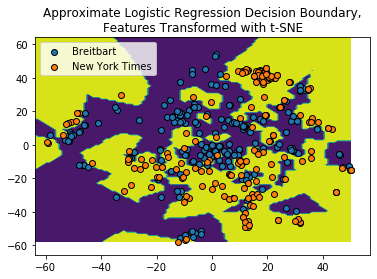

In [438]:
# 2-GRAM
#X_train_reduced_2 = TruncatedSVD(n_components=50).fit_transform(X_train_lsa_np[2])
X_train_embedded_3 = TSNE(n_components=2, perplexity=40., verbose=2).fit_transform((X_train_lsa_np[3])[:, :50])

x_tsne = X_train_embedded_3[:,0]
y_tsne = X_train_embedded_3[:,1]
#x_tsne = x_tsne[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]
#y_tsne = y_tsne[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])]

# random forest best model
model = LogisticRegression(C=6.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
clf = model.fit((X_train_lsa_np[3])[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])],
                y_train_np[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])])               
y_train_embedded_3_pred = clf.predict(X_train_lsa_np[3])

# color points in grid as nearest neighbor of what their true point was classified as
fig, ax = plt.subplots()
one_nn = KNeighborsClassifier(n_neighbors=1).fit(X_train_embedded_3[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])],
                                                 y_train_embedded_3_pred[np.logical_or(y_train_np == cls_idx[0], y_train_np == cls_idx[1])])
xx, yy = get_meshgrid(x_tsne, y_tsne, delta=1)
plot_contours(ax, one_nn, xx, yy)

# scatter plot of Breitbart and New York Times posts
for j in range(2):
    ax.scatter(x_tsne[y_train_np==cls_idx[j]], y_tsne[y_train_np==cls_idx[j]], edgecolors='k', label=legend_labels[cls_idx[j]])
    ax.legend()
plt.title('Approximate Logistic Regression Decision Boundary,\nFeatures Transformed with t-SNE')
#ax.scatter(X_train_embedded_2[:,0], X_train_embedded_2[:,1], c=y_train['title'], cmap=plt.cm.coolwarm, s=20, edgecolors='k')

In [254]:
#print(vectorizers[1]['title'][2].get_feature_names())
#print(vectorizers[2]['title'][2].get_feature_names())
#print(vectorizers[3]['title'][2].get_feature_names())
print(type(best_conf_mat[13]))
print(best_conf_mat[13])
print(best_conf_mat[13].to_numpy())

# TODO: convert to a numpy array so confusion matrix can be plotted for each top model
# TODO: confusion matrices for terrible results so that direct comparison can be made to RNN

<class 'pandas.core.frame.DataFrame'>
predicted labels     Atlantic  Breitbart  Business Insider  Buzzfeed News  \
true labels                                                                 
Atlantic                   18          1                 2              1   
Breitbart                   2         25                 0              3   
Business Insider            3          0                18              2   
Buzzfeed News               2          2                 0             28   
CNN                         2          0                 0              1   
Fox News                    0          0                 0              1   
Guardian                    5          0                 1              5   
NPR                        10          1                 2              2   
National Review             5          1                 0              2   
New York Post               0          1                 7              2   
New York Times              1         

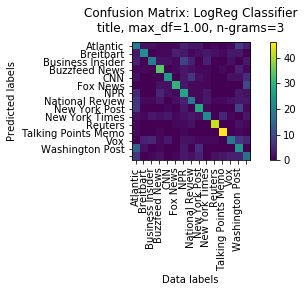

In [281]:
publisher_list = ['Atlantic', 'Breitbart', 'Business Insider', 'Buzzfeed News', 'CNN', 'Fox News', 'NPR', 'National Review', 'New York Post', 'New York Times', 'Reuters', 'Talking Points Memo', 'Vox', 'Washington Post']
def show_confusion_mat(confusion_mat):
    plt.cla()
    plt.imshow(confusion_mat)

    plt.xlabel('Data labels')
    plt.ylabel('Predicted labels')

    #plt.xlim(-0.5, 14.5)
    #plt.ylim(-1, 15)
    plt.xticks(np.arange(15), publisher_list, rotation=90)
    plt.yticks(np.arange(15), publisher_list, rotation=0)
    plt.ylim(-0.5, 14.5)
    plt.gca().invert_yaxis()
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar()
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(8) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(8) 
    #plt.show()

for j in range(3, 29):
    plt.clf()
    show_confusion_mat(best_conf_mat[j].to_numpy())
    plt.title('Confusion Matrix: %s Classifier\n%s, max_df=%.2f, n-grams=%d' % (algorithm_comparison.loc[j, 'algorithm'], algorithm_comparison.loc[j, 'use_title'], algorithm_comparison.loc[j, 'max_df'], algorithm_comparison.loc[j, 'n-gram']), pad=10)
    plt.savefig('conf_mat_report_%d.png' % (j))

In [270]:
print(label_dict)
for j in range(15):
    #print(X_test['title'][50*j])
    print(y_test_final['title'][2000*j])
    print(label_dict_inv[y_test_final['title'][2000*j]])

{'Breitbart': 0, 'Washington Post': 1, 'CNN': 2, 'Business Insider': 3, 'Buzzfeed News': 4, 'NPR': 5, 'New York Times': 6, 'Reuters': 7, 'New York Post': 8, 'Vox': 9, 'Talking Points Memo': 10, 'Guardian': 11, 'Atlantic': 12, 'National Review': 13, 'Fox News': 14}
6
New York Times
0
Breitbart
2
CNN
3
Business Insider
12
Atlantic
14
Fox News
10
Talking Points Memo
4
Buzzfeed News
13
National Review
8
New York Post
11
Guardian
5
NPR
7
Reuters
9
Vox
1
Washington Post


In [253]:
# TODO: print most commonly occurring root nodes
root_nodes = [best_models[7].estimators_[j].tree_.feature[0] for j in range(200)]
unique, counts = np.unique(np.array(root_nodes), return_counts=True)
dic = dict(zip(unique, counts))
s_dic = sorted(dic.items(), key=lambda tup: tup[1])
print(s_dic[-5:]) # top 5 most common root nodes are 8, 17, 12, 1, 0; we expect 1 and 0 to be some of the best determining features because they explain most of the variance in the original dataset
# these are important features, so we will plot decsion boundary on X[0]-X[1] plane, and X[0]-X[8], X[1]-X[8] plane

[(0, 7), (1, 7), (12, 7), (17, 7), (8, 10)]


In [236]:
print(X_test_final['content'])

0        washington        congressional republicans ha...
1        after the bullet shell get count   the blood d...
2        when walt disney  s   bambi   open in        c...
3        death may be the great equalizer   but be not ...
4        seoul   south korea        north korea  s lead...
5        london        queen elizabeth ii   who have be...
6        beijing        president tsai    of taiwan sha...
7        danny cahill stand   slightly daze   in a bliz...
8        just how    be hillary kerr   the     founder ...
9        angel be everywhere in the mu iz family  s apa...
10       with donald j  trump about to take control of ...
11       thompsons   tex          can one of the most p...
12       west palm beach   florida        when    donal...
13       this article be part of a series aim at help n...
14        s the season for family travel and photo     ...
15       finally   the second avenue subway open in new...
16          page into the    journal find in dylann s  .

In [408]:
from joblib import dump, load

dump(best_models[7], 'best_model_7.joblib')
dump(best_models[13], 'best_model_13.joblib')
dump(best_models[28], 'best_model_28.joblib')
dump(vectorizers[2]['title'][2], 'vectorizer_2_title_2.joblib')
dump(vectorizers[3]['title'][2], 'vectorizer_3_title_2.joblib')
dump(lsa[2]['title'][2], 'lsa_2_title_2.joblib')
dump(lsa[3]['title'][2], 'lsa_3_title_2.joblib')

['lsa_3_title_2.joblib']

In [415]:
dump(best_models, 'best_model_dict.joblib')

['best_model_dict.joblib']

In [416]:
dump(lsa, 'lsa_dict.joblib')
dump(vectorizers, 'vectorizer_dict.joblib')

['vectorizer_dict.joblib']